 # DATA PREPROCESSING

### IMPORT LIBRARIES

In [1]:
# !pip install nltk
# !pip install scikit-learn
# !pip install seaborn
# !pip install matplotlib
# !pip install wordcloud

In [2]:
import re
import string
import json
import nltk
import glob
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import ngrams
from nltk import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

In [3]:
#Download all the required files
nltk.download('stopwords') # downloads stopword
nltk.download('wordnet') # downloads wordnet
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
!python3 -m nltk.downloader wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora

In [5]:
lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

# loads english stopwords
stopword_list = nltk.corpus.stopwords.words('english')

## LOAD DATA

In [6]:
def load_articles():
    """Load multiple articles from various sources"""
    articles = []
    try:
        original_articles = pd.read_json('/kaggle/input/articles/indianExp.json')
        with open("/kaggle/input/articles/indianExp.json",encoding='utf-8') as f:
            data = json.load(f) 
            articles += data
    except json.decoder.JSONDecodeError as e:
        data = []
    return original_articles, articles

In [7]:
def total_split(articles):
    count_dict = {'India':0, 'Political Pulse':0, 'Sports':0, 'Cities':0, 'Lifestyle':0}
    total = 0
    lis = []
    for article in tqdm(articles):
        if(article['genre']!=None):
            count_dict[article['genre']] += 1
            total += 1
            lis.append(article['genre'])
    return count_dict, lis, total

In [8]:
original_articles, articles = load_articles()
print('Total documents loaded:',len(articles))
original_articles.head()

Total documents loaded: 12363


heading author  \
0  Pro-Khalistan actors using gangs, nexus firmed...          
1  First time in four years, NREGS jobs in Jan-Fe...          
2  Rahul Gandhi to Lok Sabha Speaker: ‘Scurrilous...          
3  Assam Class 10 board exam paper leak govt’s fa...          
4  Minors assaulted, their hair chopped off at Ch...          

                 publish_date  \
0    March 28, 2023 03:19 IST   
1   March 28, 2023  07:38 IST   
2   March 21, 2023  19:34 IST   
3    March 16, 2023 14:14 IST   
4    March 16, 2023 17:12 IST   

                                            overview  \
0  Two cases were registered against gangsters La...   
1  The demand for work under NREGS had jumped fol...   
2  The proceedings of both Houses have been marre...   
3  Noisy scenes were witnessed in the Assam assem...   
4  A couple of videos, where the accused could be...   

                                                link  \
0  https://indianexpress.com/article/india/pro-kh...   
1  https://indianexpress.com/article/india/first-...   
2  https://indianexpress.com/article/india/right-...   
3  https://indianexpress.com/article/india/assam-...   
4  https://indianexpress.com/article/india/minors...   

                                             content  genre  
0  [A number of criminal gangs active in North In...  India  
1  [The employment generated in January and Febru...  India  
2  [CONGRESS LEADER Rahul Gandhi has written to L...  India  
3  [While accepting that the Assam Class 10 board...  India  
4  [At least five students, aged 12 to 13 years, ...  India

In [9]:
article_contents = []
for article in tqdm(articles):
    if(article['heading']!=None):
        article_contents.append(article['heading'])
print('Content in an article: ', *article_contents[:10], end='\n', sep="\n")


100%|██████████| 12363/12363 [00:00<00:00, 962258.39it/s]

Content in an article: 
Pro-Khalistan actors using gangs, nexus firmed up in jails in India and abroad, NIA says in chargesheet
First time in four years, NREGS jobs in Jan-Feb below pre-Covid level
Rahul Gandhi to Lok Sabha Speaker: ‘Scurrilous, defamatory… let me respond to BJP’
Assam Class 10 board exam paper leak govt’s failure: CM Himanta Biswa Sarma
Minors assaulted, their hair chopped off at Chhattisgarh residential school, eight students booked one sent to jail
Govt nod to acquire defence hardware worth Rs 70,500 crore
‘Rigid stance’: RS Chairman Dhankhar’s meeting with ministers, Oppn leaders fails to break House impasse
PFI recruits underwent 3-stage training programme: NIA chargesheet
J&K leaders meet EC, ask for Assembly elections to be announced
Amritpal Singh still on the run: Centre asks BSF, SSB to be alert at border posts


In [10]:
count_dict, genre_lis, total = total_split(articles)
count_dict

100%|██████████| 12363/12363 [00:00<00:00, 938877.07it/s]


{'India': 2473,
 'Entertainment': 0,
 'Political Pulse': 2495,
 'Technology': 0,
 'Sports': 2452,
 'Cities': 2461,
 'Lifestyle': 2482}

## DATASET ANALYSIS

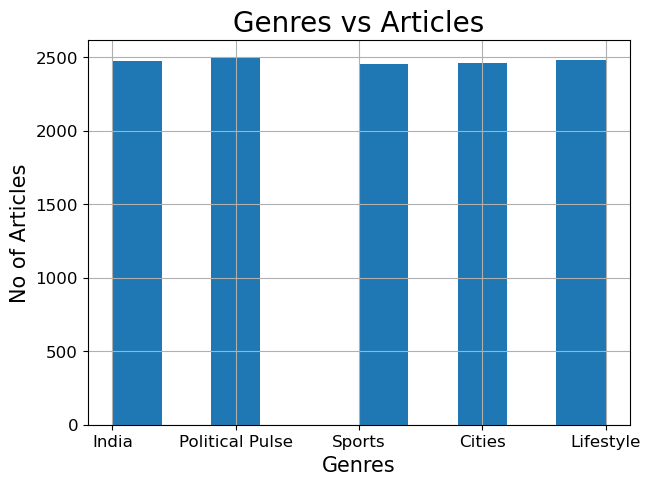

In [11]:
fig = plt.figure(figsize = (7,5))
ax = fig.gca()
original_articles['genre'].hist(ax=ax)
plt.xlabel('Genres',fontsize=15)
plt.ylabel('No of Articles',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Genres vs Articles',fontsize=20)
plt.show()

# TEXT NORMALISATION

## DATA CLEANING

In [12]:
def remove_punctuations(text):
    """Removes punctuation from text"""
    text = text.strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    return text

def decontact(phrase):
    """Removes apostrophe word and numbers"""
    # number
    phrase = re.sub(r'\b\d+\b', '', phrase)
    phrase = re.sub(r'\’', '\'', phrase)

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [13]:
res = []
for content in tqdm(article_contents):
    res.append(decontact(content))
    
article_contents = res
print('After removal of apostropes and numbers', *article_contents[:10], end='\n', sep="\n")

100%|██████████| 12363/12363 [00:00<00:00, 54302.92it/s]

After removal of apostropes and numbers
Pro-Khalistan actors using gangs, nexus firmed up in jails in India and abroad, NIA says in chargesheet
First time in four years, NREGS jobs in Jan-Feb below pre-Covid level
Rahul Gandhi to Lok Sabha Speaker: ‘Scurrilous, defamatory… let me respond to BJP'
Assam Class  board exam paper leak govt is failure: CM Himanta Biswa Sarma
Minors assaulted, their hair chopped off at Chhattisgarh residential school, eight students booked one sent to jail
Govt nod to acquire defence hardware worth Rs , crore
‘Rigid stance': RS Chairman Dhankhar is meeting with ministers, Oppn leaders fails to break House impasse
PFI recruits underwent -stage training programme: NIA chargesheet
J&K leaders meet EC, ask for Assembly elections to be announced
Amritpal Singh still on the run: Centre asks BSF, SSB to be alert at border posts


In [14]:

res = []
for content in tqdm(article_contents):
    res.append(remove_punctuations(content))

article_contents = res
print('After removal of punctuations:  \n', *article_contents[:10], end='\n', sep="\n")


100%|██████████| 12363/12363 [00:00<00:00, 101703.58it/s]

After removal of punctuations:  

ProKhalistan actors using gangs nexus firmed up in jails in India and abroad NIA says in chargesheet
First time in four years NREGS jobs in JanFeb below preCovid level
Rahul Gandhi to Lok Sabha Speaker Scurrilous defamatory let me respond to BJP
Assam Class  board exam paper leak govt is failure CM Himanta Biswa Sarma
Minors assaulted their hair chopped off at Chhattisgarh residential school eight students booked one sent to jail
Govt nod to acquire defence hardware worth Rs  crore
Rigid stance RS Chairman Dhankhar is meeting with ministers Oppn leaders fails to break House impasse
PFI recruits underwent stage training programme NIA chargesheet
JK leaders meet EC ask for Assembly elections to be announced
Amritpal Singh still on the run Centre asks BSF SSB to be alert at border posts


## TOKENISATION

In [15]:
def generate_tokens(text):
    """Generates tokens using tokenizer"""
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens

In [16]:
article_tokens = []
for content in tqdm(article_contents):
    article_tokens.append(generate_tokens(content))

print('Generation of tokens: \n', *article_tokens[:10], end='\n', sep='\n')


100%|██████████| 12363/12363 [00:00<00:00, 20056.49it/s]

Generation of tokens: 

['prokhalistan', 'actors', 'using', 'gangs', 'nexus', 'firmed', 'up', 'in', 'jails', 'in', 'india', 'and', 'abroad', 'nia', 'says', 'in', 'chargesheet']
['first', 'time', 'in', 'four', 'years', 'nregs', 'jobs', 'in', 'janfeb', 'below', 'precovid', 'level']
['rahul', 'gandhi', 'to', 'lok', 'sabha', 'speaker', 'scurrilous', 'defamatory', 'let', 'me', 'respond', 'to', 'bjp']
['assam', 'class', 'board', 'exam', 'paper', 'leak', 'govt', 'is', 'failure', 'cm', 'himanta', 'biswa', 'sarma']
['minors', 'assaulted', 'their', 'hair', 'chopped', 'off', 'at', 'chhattisgarh', 'residential', 'school', 'eight', 'students', 'booked', 'one', 'sent', 'to', 'jail']
['govt', 'nod', 'to', 'acquire', 'defence', 'hardware', 'worth', 'rs', 'crore']
['rigid', 'stance', 'rs', 'chairman', 'dhankhar', 'is', 'meeting', 'with', 'ministers', 'oppn', 'leaders', 'fails', 'to', 'break', 'house', 'impasse']
['pfi', 'recruits', 'underwent', 'stage', 'training', 'programme', 'nia', 'chargesheet']
['

In [17]:
from collections import defaultdict
freq = defaultdict(int)
for tokens in tqdm(article_tokens):
    for token in tokens:
        freq[token] += 1
article_tokens = [[token for token in tokens if freq[token] > 1] for tokens in article_tokens]

print('\n non-repeated tokens removal', article_tokens[0])

100%|██████████| 12363/12363 [00:00<00:00, 224538.21it/s]



 non-repeated tokens removal ['prokhalistan', 'actors', 'using', 'gangs', 'nexus', 'up', 'in', 'jails', 'in', 'india', 'and', 'abroad', 'nia', 'says', 'in', 'chargesheet']


# FEATURE EXTRACTION

### STOP-WORD ELIMINATION

In [18]:
def remove_stopwords(tokens):
    """Removes stopwords from stopword list"""
    texts = [word for word in tokens if word not in stopword_list]
    # texts = ' '.join(texts)
    return texts

In [19]:
res = []
for tokens in tqdm(article_tokens):
    res.append(remove_stopwords(tokens))
article_tokens = res
print('After Removing stop-words: \n', *article_tokens[:10], end='\n', sep="\n")


100%|██████████| 12363/12363 [00:00<00:00, 29629.32it/s]

After Removing stop-words: 

['prokhalistan', 'actors', 'using', 'gangs', 'nexus', 'jails', 'india', 'abroad', 'nia', 'says', 'chargesheet']
['first', 'time', 'four', 'years', 'nregs', 'jobs', 'level']
['rahul', 'gandhi', 'lok', 'sabha', 'speaker', 'let', 'respond', 'bjp']
['assam', 'class', 'board', 'exam', 'paper', 'leak', 'govt', 'failure', 'cm', 'himanta', 'biswa', 'sarma']
['minors', 'assaulted', 'hair', 'chopped', 'chhattisgarh', 'residential', 'school', 'eight', 'students', 'booked', 'one', 'sent', 'jail']
['govt', 'nod', 'acquire', 'defence', 'worth', 'rs', 'crore']
['rigid', 'stance', 'rs', 'chairman', 'dhankhar', 'meeting', 'ministers', 'oppn', 'leaders', 'fails', 'break', 'house', 'impasse']
['pfi', 'recruits', 'stage', 'training', 'programme', 'nia', 'chargesheet']
['jk', 'leaders', 'meet', 'ec', 'ask', 'assembly', 'elections', 'announced']
['amritpal', 'singh', 'still', 'run', 'centre', 'asks', 'bsf', 'ssb', 'alert', 'border', 'posts']


## LEMMATIZATION

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def capture_lemmatization(tokens):
    """Captures lemmatization and translates word accordingly"""
    tokens = [lemmatizer.lemmatize(
        token, get_wordnet_pos(token)) for token in tokens]
    return tokens

In [21]:
res = []
for tokens in tqdm(article_tokens):
    res.append(capture_lemmatization(tokens))
article_tokens = res

print('After lemmatization: \n', *article_tokens[:10], end='\n', sep="\n")


100%|██████████| 12363/12363 [00:23<00:00, 523.81it/s]

After lemmatization: 

['prokhalistan', 'actor', 'use', 'gang', 'nexus', 'jail', 'india', 'abroad', 'nia', 'say', 'chargesheet']
['first', 'time', 'four', 'year', 'nregs', 'job', 'level']
['rahul', 'gandhi', 'lok', 'sabha', 'speaker', 'let', 'respond', 'bjp']
['assam', 'class', 'board', 'exam', 'paper', 'leak', 'govt', 'failure', 'cm', 'himanta', 'biswa', 'sarma']
['minor', 'assault', 'hair', 'chopped', 'chhattisgarh', 'residential', 'school', 'eight', 'student', 'book', 'one', 'sent', 'jail']
['govt', 'nod', 'acquire', 'defence', 'worth', 'r', 'crore']
['rigid', 'stance', 'r', 'chairman', 'dhankhar', 'meeting', 'minister', 'oppn', 'leader', 'fails', 'break', 'house', 'impasse']
['pfi', 'recruit', 'stage', 'training', 'programme', 'nia', 'chargesheet']
['jk', 'leader', 'meet', 'ec', 'ask', 'assembly', 'election', 'announce']
['amritpal', 'singh', 'still', 'run', 'centre', 'asks', 'bsf', 'ssb', 'alert', 'border', 'post']


### GENERATE FINAL LIST OF TOKENS

In [22]:
article_vec = list()
for tokens in tqdm(article_tokens):
    modified_text = ' '.join(tokens)
    article_vec.append(modified_text)

with open('/kaggle/working/preprocessed_data.txt','w') as fp:
    for article in tqdm(article_vec):
        fp.write("%s\n" % article)

100%|██████████| 12363/12363 [00:00<00:00, 1131100.70it/s]


# WORD VECTORISATION

## TF-IDF CALCULATION

TERM-FREQUENCY = no of occurance of term in document / total no of terms$

INVERSE DOCUMENT FREQUENCY = log(number of documents/ number of documents containing that term)

### UNIGRAM VECTORIZATION

In [24]:
article_vec = []
with open('/kaggle/working/preprocessed_data.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        article_vec.append(x)

prokhalistan actor use gang nexus jail india abroad nia say chargesheet


In [25]:
vectorizer1 = TfidfVectorizer(strip_accents='ascii', stop_words='english')
vectorizer1.fit(article_vec)
tfidf_matrix1 = vectorizer1.transform(article_vec)

print(vectorizer1.vocabulary_)

{'prokhalistan': 5790, 'actor': 115, 'use': 7863, 'gang': 2919, 'nexus': 5034, 'jail': 3765, 'india': 3537, 'abroad': 53, 'nia': 5041, 'say': 6565, 'chargesheet': 1308, 'time': 7535, 'year': 8222, 'nregs': 5114, 'job': 3844, 'level': 4243, 'rahul': 5945, 'gandhi': 2915, 'lok': 4325, 'sabha': 6435, 'speaker': 7041, 'let': 4239, 'respond': 6235, 'bjp': 895, 'assam': 535, 'class': 1424, 'board': 946, 'exam': 2474, 'paper': 5341, 'leak': 4195, 'govt': 3060, 'failure': 2586, 'cm': 1460, 'himanta': 3326, 'biswa': 886, 'sarma': 6537, 'minor': 4711, 'assault': 538, 'hair': 3177, 'chopped': 1376, 'chhattisgarh': 1346, 'residential': 6223, 'school': 6589, 'student': 7203, 'book': 966, 'sent': 6689, 'nod': 5066, 'acquire': 104, 'defence': 1897, 'worth': 8190, 'crore': 1737, 'rigid': 6300, 'stance': 7110, 'chairman': 1270, 'dhankhar': 2032, 'meeting': 4613, 'minister': 4709, 'oppn': 5211, 'leader': 4190, 'fails': 2585, 'break': 1029, 'house': 3398, 'impasse': 3490, 'pfi': 5483, 'recruit': 6091, 's

In [26]:
tfidf_matrix1.shape

(12363, 8264)

## TF IDF SCORES FOR EACH ARTICLE (UNIGRAM)

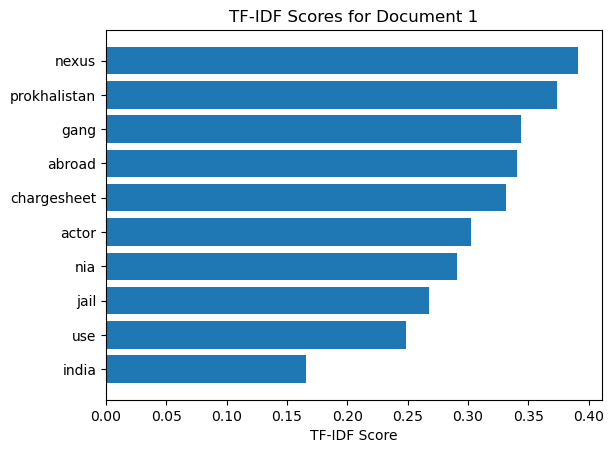

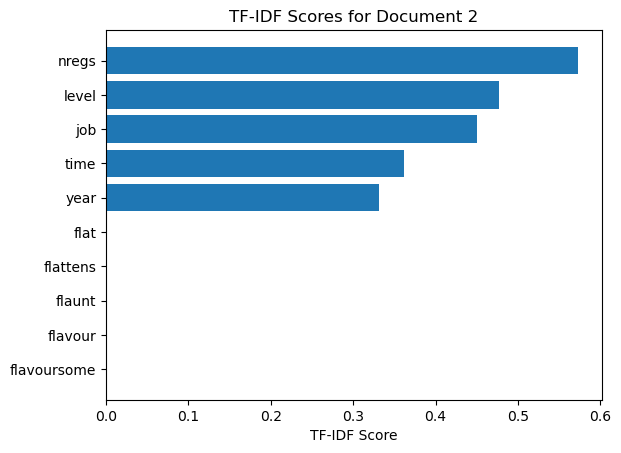

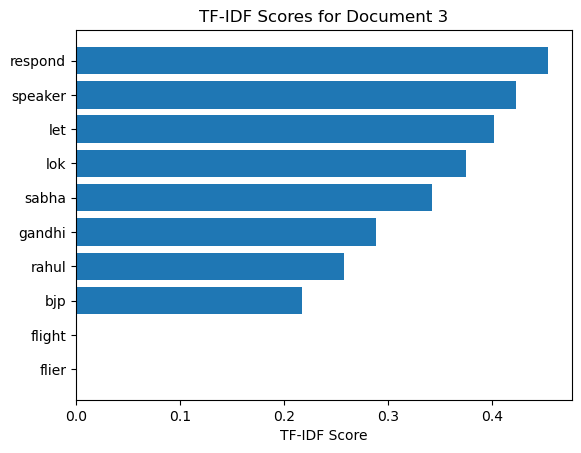

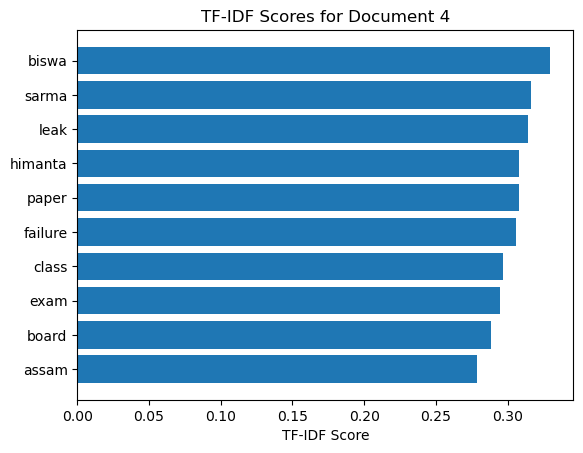

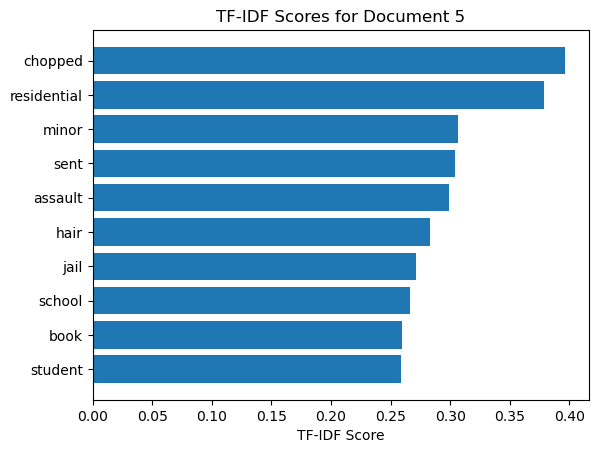

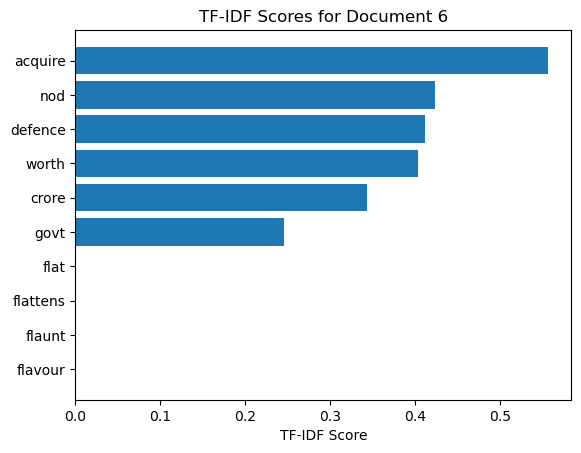

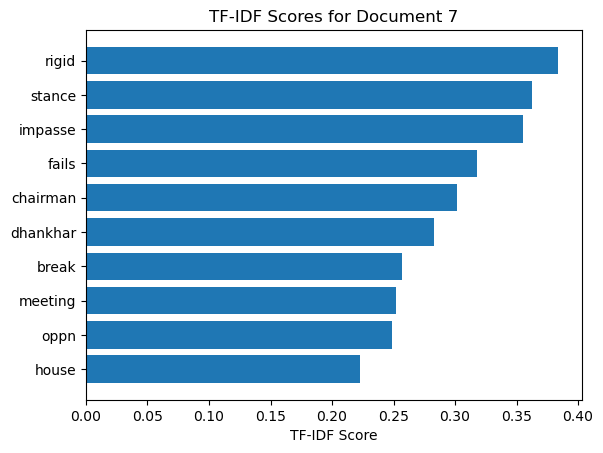

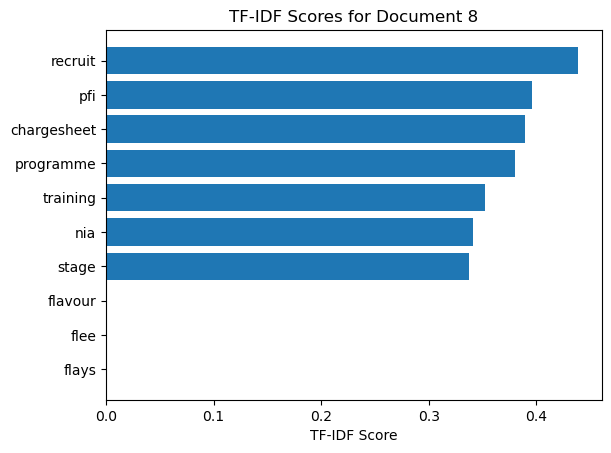

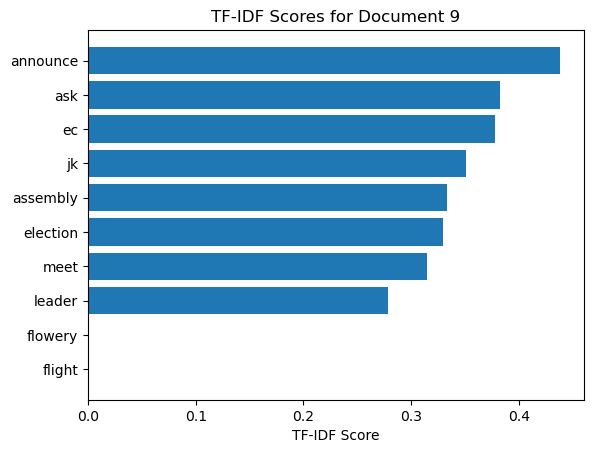

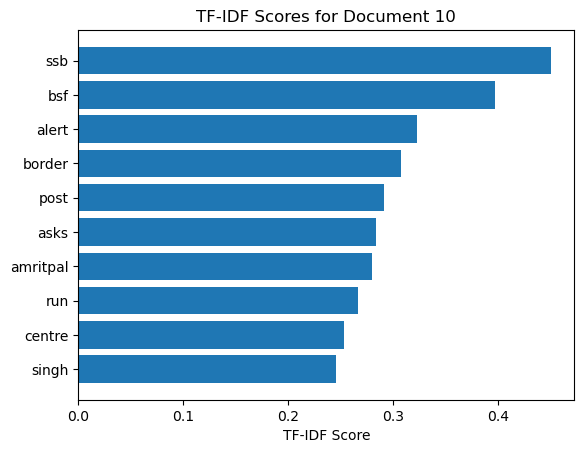

In [27]:
feature_names = vectorizer1.get_feature_names_out()
tfidf_scores = tfidf_matrix1.toarray()

# Define the number of top features to display in the bar chart
n = 10

# Loop over each document and create a bar chart of the top n TF-IDF scores
for i, doc in enumerate(article_vec):
    # Get the indices of the top n TF-IDF scores for the current document
    if i == 10: break
    top_indices = np.argsort(tfidf_scores[i])[-n:]

    # Get the top n feature names and TF-IDF scores for the current document
    top_features = [feature_names[j] for j in top_indices]
    top_scores = [tfidf_scores[i][j] for j in top_indices]

    # Create a horizontal bar chart of the top n TF-IDF scores
    fig, ax = plt.subplots()
    ax.barh(top_features, top_scores)
    ax.set_title("TF-IDF Scores for Document {}".format(i+1))
    ax.set_xlabel("TF-IDF Score")
    plt.show()


## UNIGRAM + BIGRAM

In [32]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', ngram_range=(1,2))
vectorizer.fit(article_vec)
tfidf_matrix = vectorizer.transform(article_vec)

print(vectorizer.vocabulary_)

{'prokhalistan': 52820, 'actor': 843, 'use': 71493, 'gang': 26311, 'nexus': 45825, 'jail': 34061, 'india': 32089, 'abroad': 326, 'nia': 45869, 'say': 59225, 'chargesheet': 11719, 'prokhalistan actor': 52821, 'actor use': 868, 'use gang': 71524, 'gang nexus': 26315, 'nexus jail': 45826, 'jail india': 34080, 'india abroad': 32093, 'abroad nia': 331, 'nia say': 45885, 'say chargesheet': 59308, 'time': 68654, 'year': 75483, 'nregs': 46299, 'job': 34591, 'level': 38350, 'time year': 68802, 'year nregs': 75593, 'nregs job': 46305, 'job level': 34607, 'rahul': 54178, 'gandhi': 26139, 'lok': 39254, 'sabha': 58554, 'speaker': 64079, 'let': 38279, 'respond': 56789, 'bjp': 7510, 'rahul gandhi': 54220, 'gandhi lok': 26228, 'lok sabha': 39255, 'sabha speaker': 58595, 'speaker let': 64094, 'let respond': 38302, 'respond bjp': 56790, 'assam': 4280, 'class': 12846, 'board': 8213, 'exam': 22184, 'paper': 48302, 'leak': 37958, 'govt': 27332, 'failure': 23145, 'cm': 13125, 'himanta': 30319, 'biswa': 7451

In [33]:
tfidf_matrix.shape

(12363, 76010)

## TF IDF SCORES FOR EACH ARTICLE (UNI + BIGRAM)

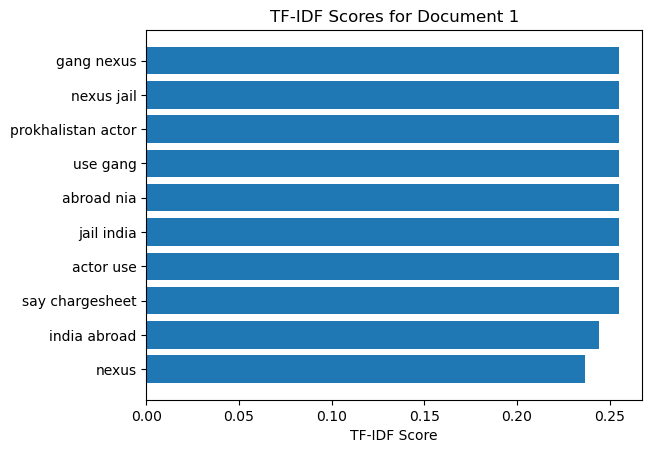

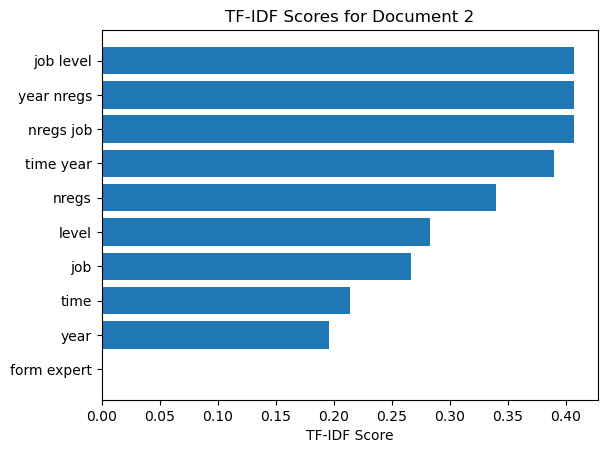

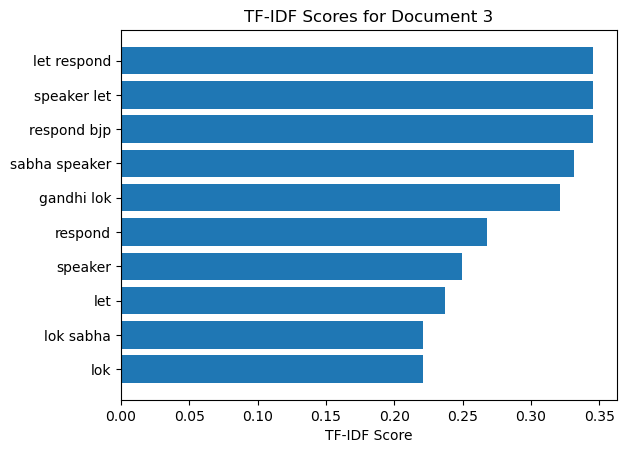

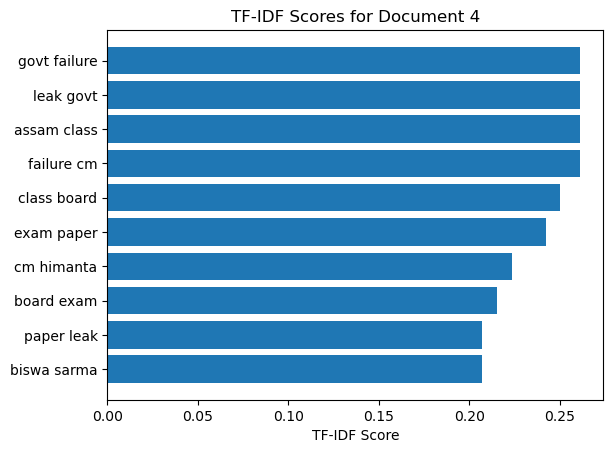

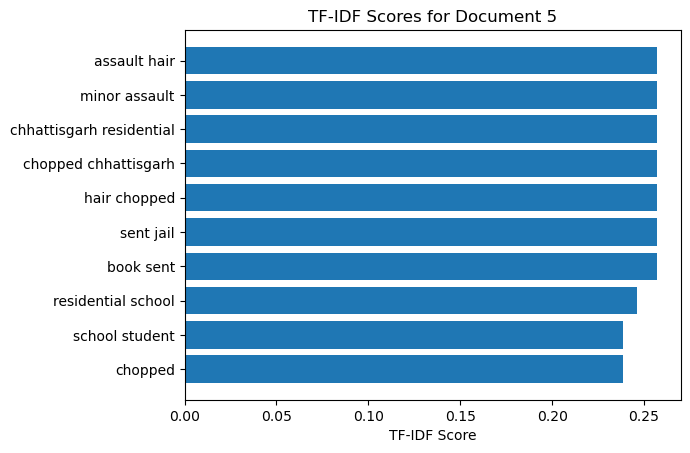

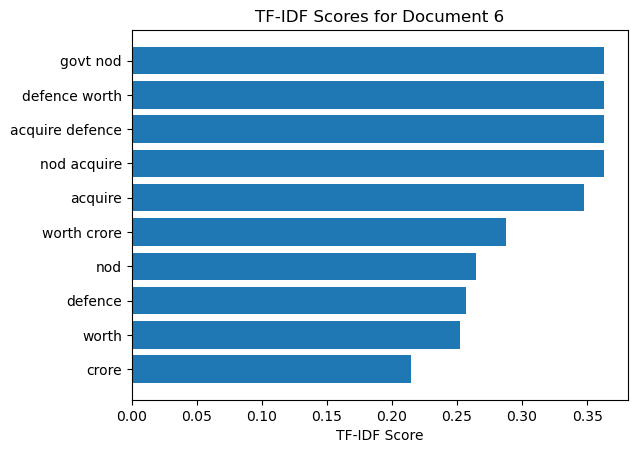

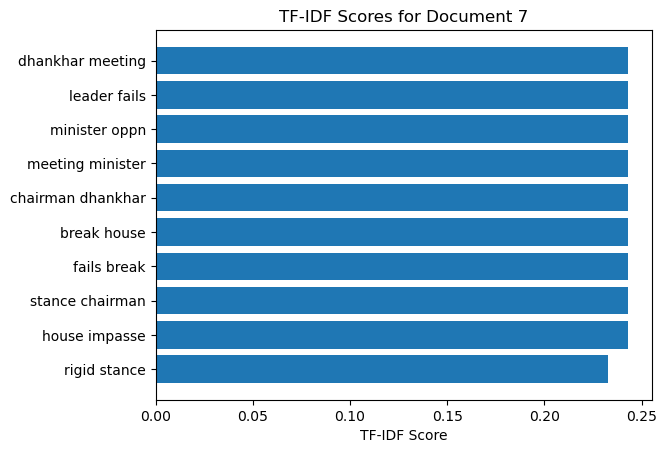

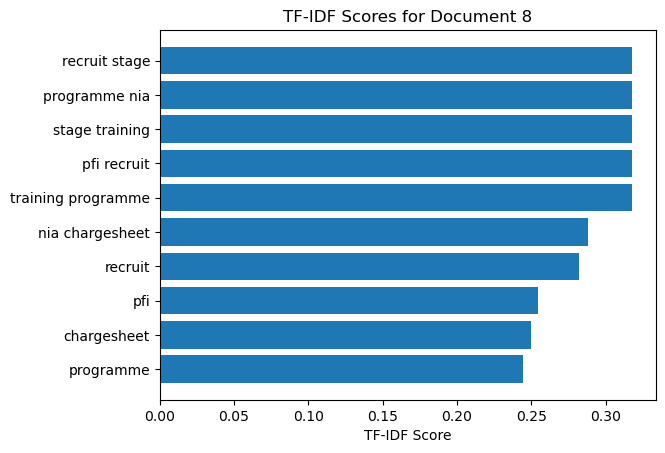

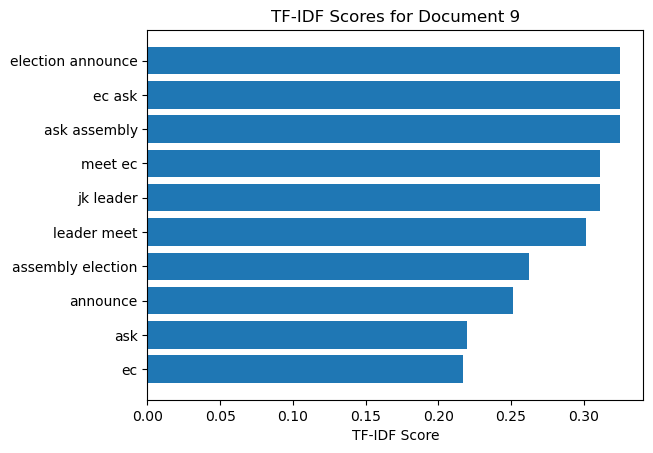

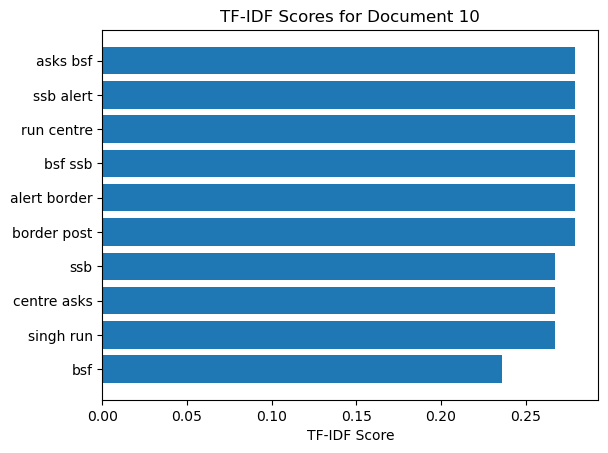

In [34]:
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Define the number of top features to display in the bar chart
n = 10

# Loop over each document and create a bar chart of the top n TF-IDF scores
for i, doc in enumerate(article_vec):
    # Get the indices of the top n TF-IDF scores for the current document
    if i == 10: break
    top_indices = np.argsort(tfidf_scores[i])[-n:]

    # Get the top n feature names and TF-IDF scores for the current document
    top_features = [feature_names[j] for j in top_indices]
    top_scores = [tfidf_scores[i][j] for j in top_indices]

    # Create a horizontal bar chart of the top n TF-IDF scores
    fig, ax = plt.subplots()
    ax.barh(top_features, top_scores)
    ax.set_title("TF-IDF Scores for Document {}".format(i+1))
    ax.set_xlabel("TF-IDF Score")
    plt.show()

In [35]:
print(tfidf_matrix)

  (0, 71524)	0.25473215327493054
  (0, 71493)	0.1502937710455999
  (0, 59308)	0.25473215327493054
  (0, 59225)	0.09712332153942502
  (0, 52821)	0.25473215327493054
  (0, 52820)	0.22596861629749307
  (0, 45885)	0.2365843819779124
  (0, 45869)	0.1756522960802586
  (0, 45826)	0.25473215327493054
  (0, 45825)	0.2365843819779124
  (0, 34080)	0.25473215327493054
  (0, 34061)	0.16202381976809646
  (0, 32093)	0.2441163875945112
  (0, 32089)	0.10029870270732368
  (0, 26315)	0.25473215327493054
  (0, 26311)	0.20782084500047493
  (0, 11719)	0.2002888393838761
  (0, 868)	0.25473215327493054
  (0, 843)	0.18297230297051656
  (0, 331)	0.25473215327493054
  (0, 326)	0.20572519086872187
  (1, 75593)	0.40704901208175026
  (1, 75483)	0.1959123780768449
  (1, 68802)	0.3900855589913103
  (1, 68654)	0.213966108451781
  :	:
  (12361, 46279)	0.31448081852286514
  (12361, 46276)	0.5579413081552944
  (12361, 43054)	0.30137507338035047
  (12361, 43001)	0.180820885939818
  (12361, 35220)	0.31448081852286514
  (12

In [ ]:
import pickle

# Unigram & Bigram
pickle.dump(tfidf_matrix, open("/kaggle/working/tfidf_matrix.pickle", "wb"))
pickle.dump(vectorizer, open("/kaggle/working/vectorizer.pickle", "wb"))

# Unigram 
pickle.dump(tfidf_matrix1, open("/kaggle/working/tfidf_matrix1.pickle", "wb"))
pickle.dump(vectorizer1, open("/kaggle/working/vectorizer1.pickle", "wb"))

# SINGULAR VALUE DECOMPOSITION

$$ M = U \Sigma V^T $$
WHERE,

M -> DOCUMENT X TERMS ( TFIDF MATRIX )

U -> DOCUMENT X TOPICS

$\Sigma$ -> TOPICS X TOPICS

V -> TOPIC X TERMS

## UNIGRAM + BIGRAM SVD

In [37]:
svd_modeling= TruncatedSVD(n_components=7500, algorithm='randomized', n_iter=1, random_state=42)
for i in tqdm(range(1)):
    lsa = svd_modeling.fit_transform(tfidf_matrix)
components=svd_modeling.components_
vocab = vectorizer.get_feature_names()

100%|██████████| 1/1 [16:31<00:00, 991.40s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
pickle.dump(svd_modeling, open("/kaggle/working/svd_modeling.pickle", "wb"), protocol=4)
pickle.dump(lsa, open("/kaggle/working/lsa.pickle", "wb"))

In [39]:
svd_modeling.explained_variance_ratio_

array([1.00292821e-03, 1.78370618e-03, 1.49121145e-03, ...,
       3.91293442e-05, 3.90956381e-05, 3.90867156e-05])

In [40]:
svd_modeling.explained_variance_ratio_.sum()

0.7680815829865291

In [115]:
svd_modeling1.explained_variance_ratio_.sum() / (len(svd_modeling1.explained_variance_ratio_) / tfidf_matrix1.shape[1])

1.1000191727806004

In [41]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

print("No of components for 0.75 variance: ", select_n_components(svd_modeling.explained_variance_ratio_, 0.75))

No of components for 0.75 variance:  7066


In [42]:
Sigma = svd_modeling.singular_values_
V_T = svd_modeling.components_.T

<AxesSubplot:>

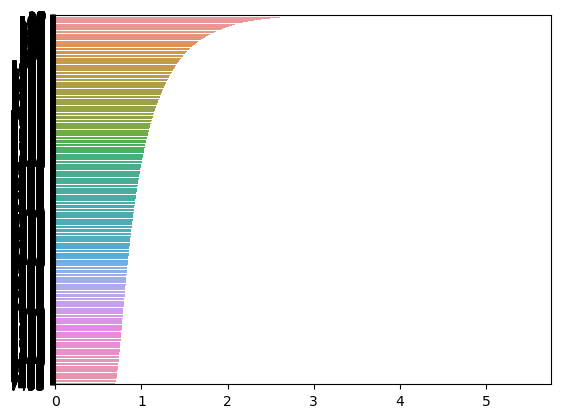

In [128]:
sns.barplot(y=list(range(len(Sigma))), x = Sigma, orient="h")

## TOPICS FORMED WITH SVD (UNI + BIGRAM)

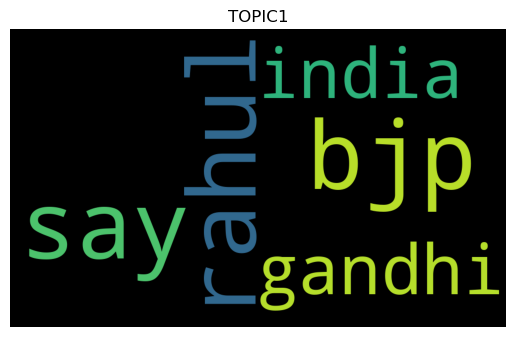

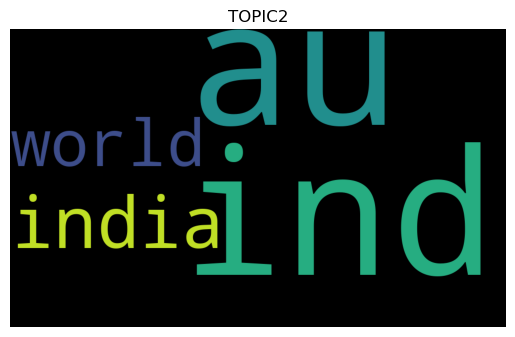

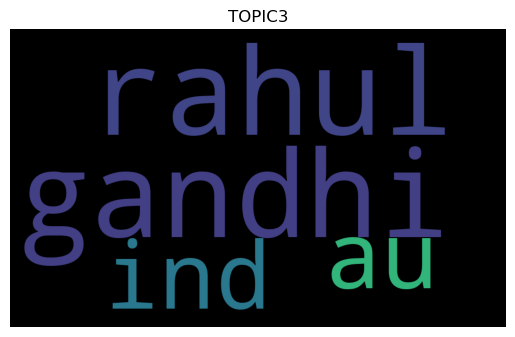

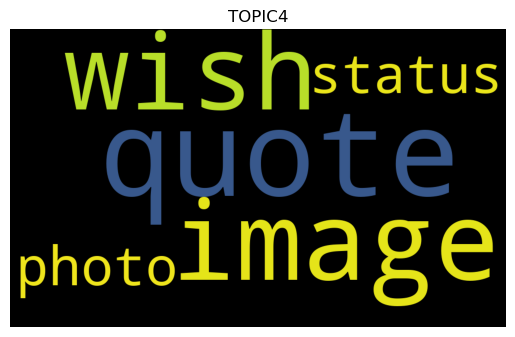

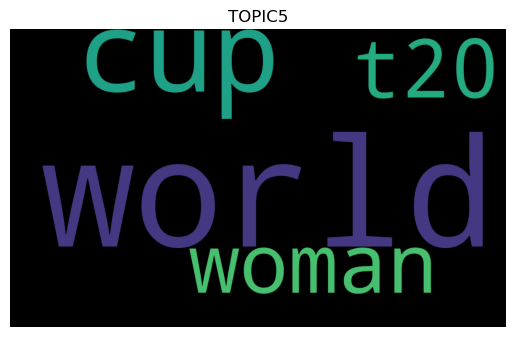

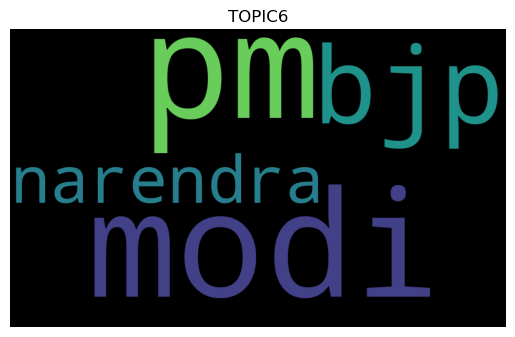

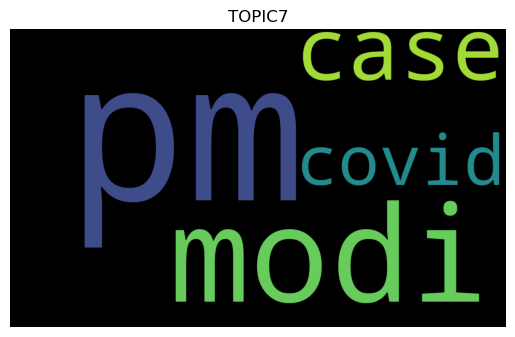

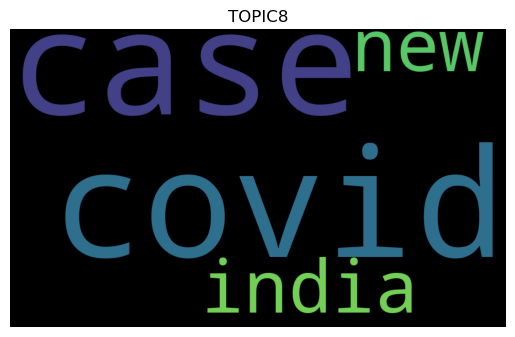

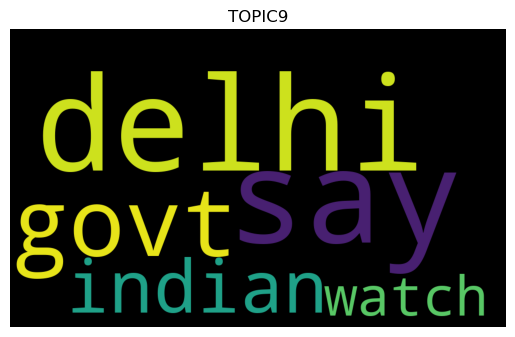

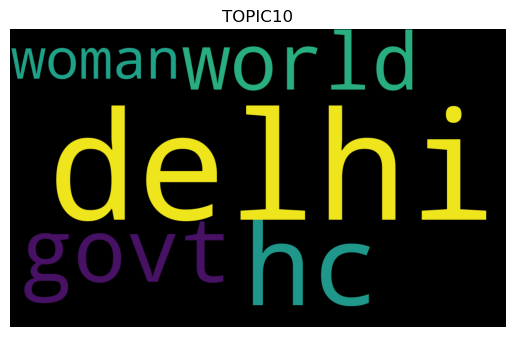

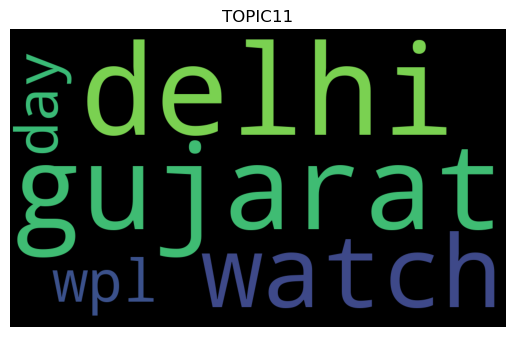

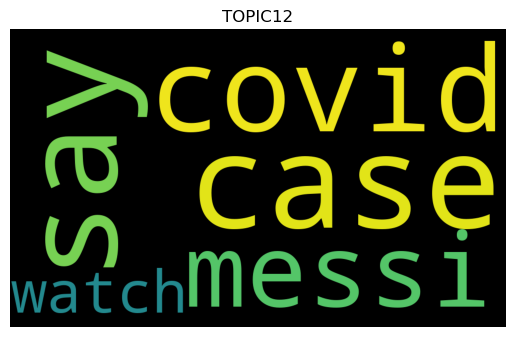

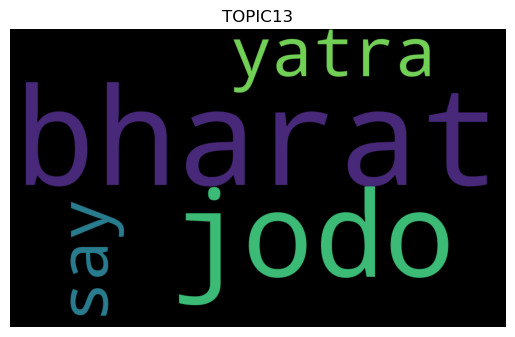

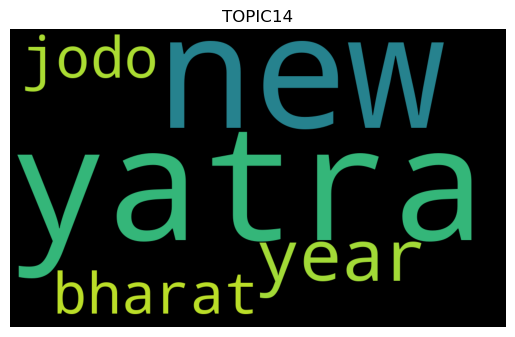

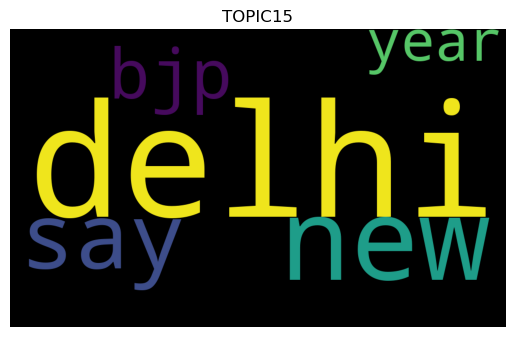

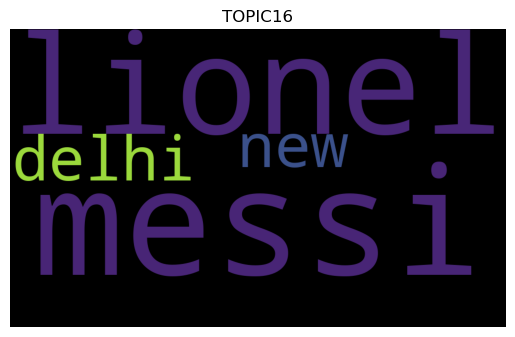

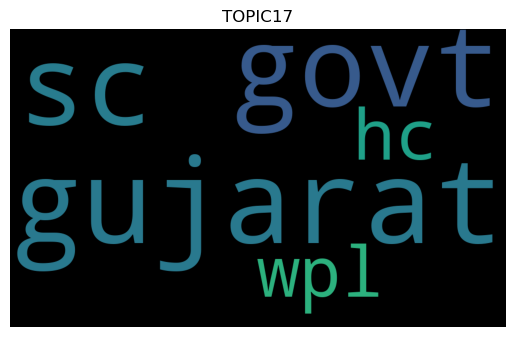

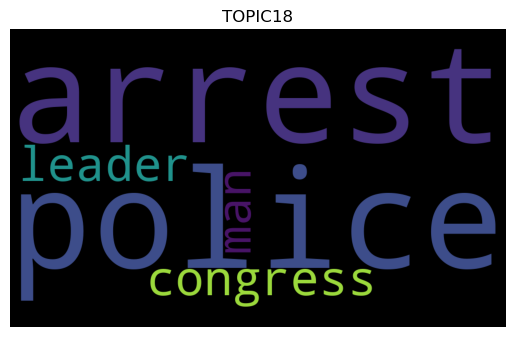

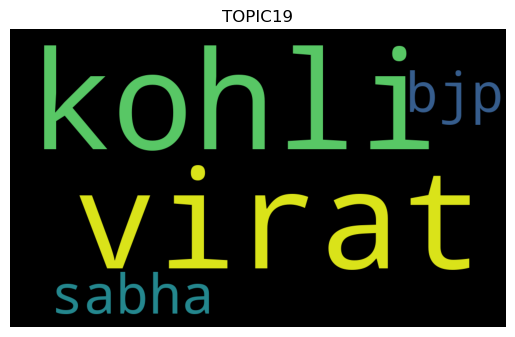

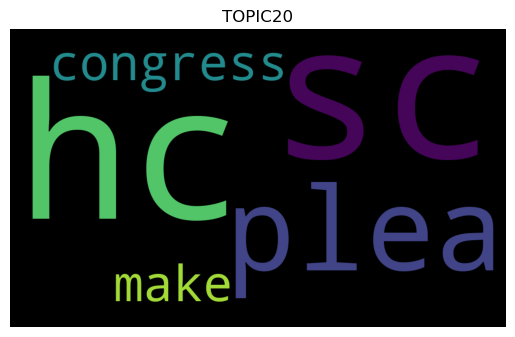

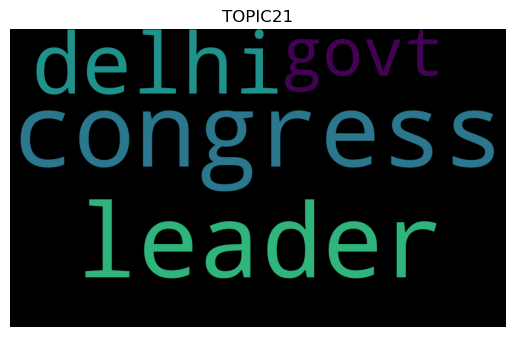

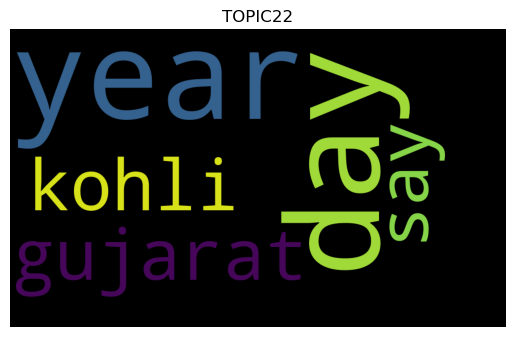

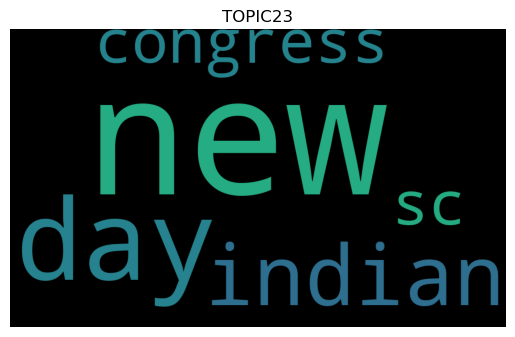

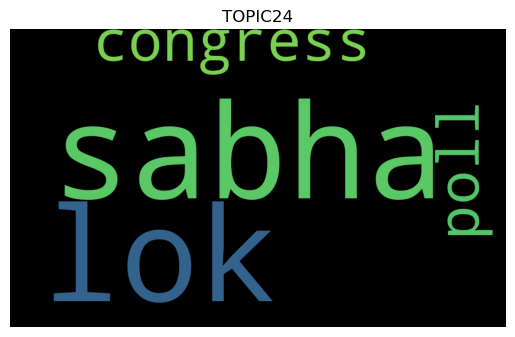

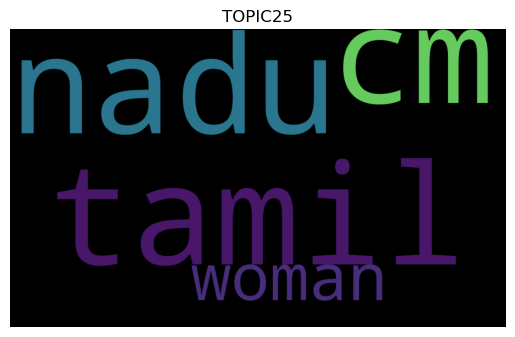

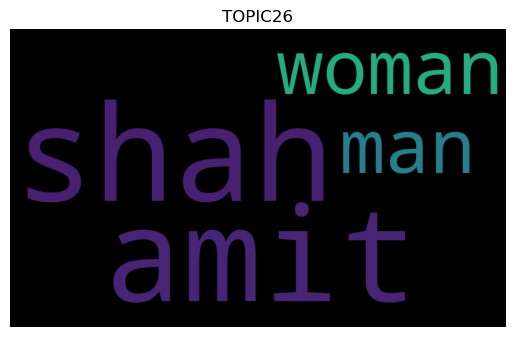

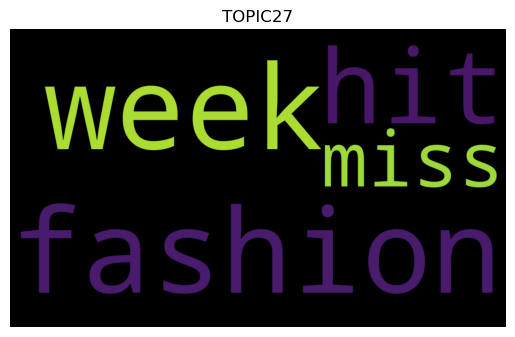

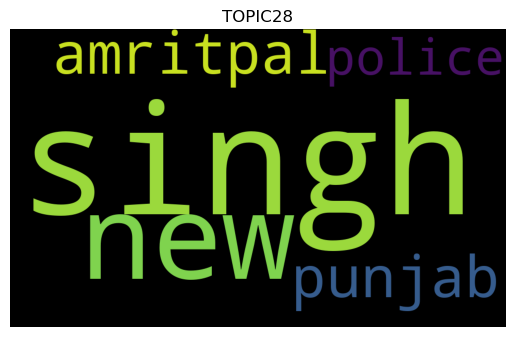

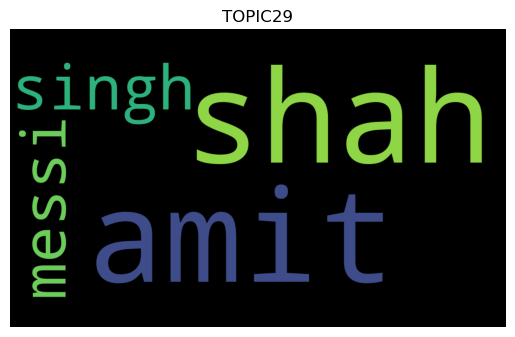

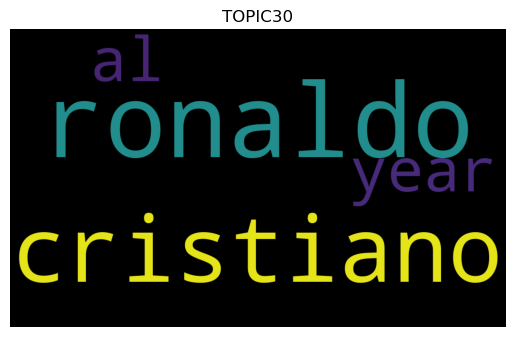

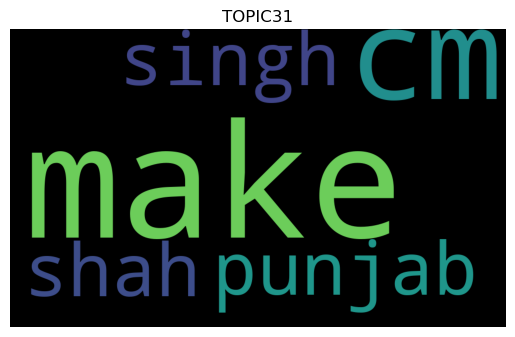

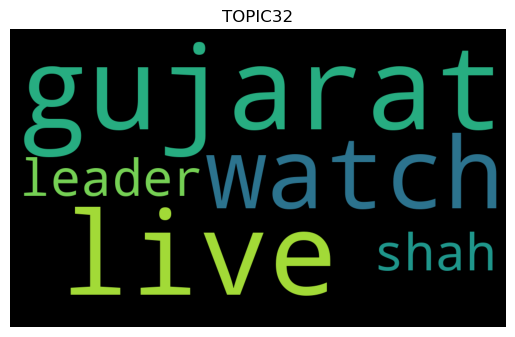

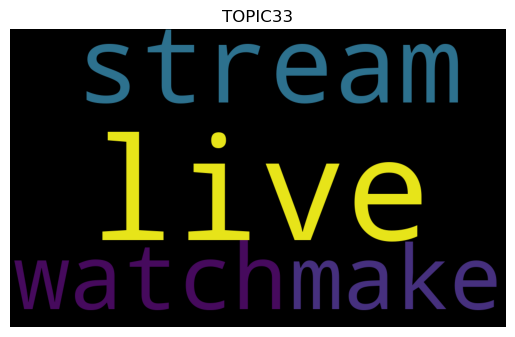

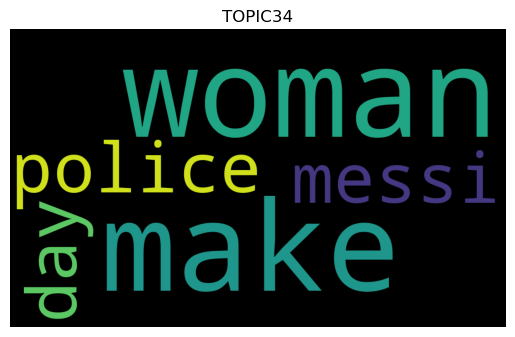

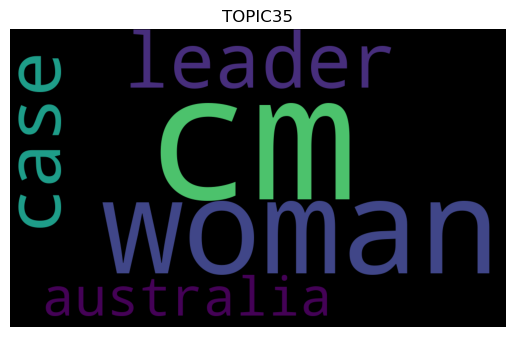

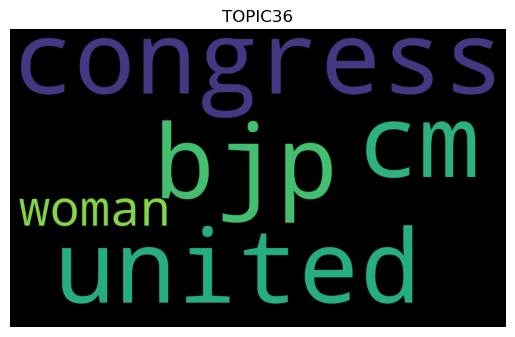

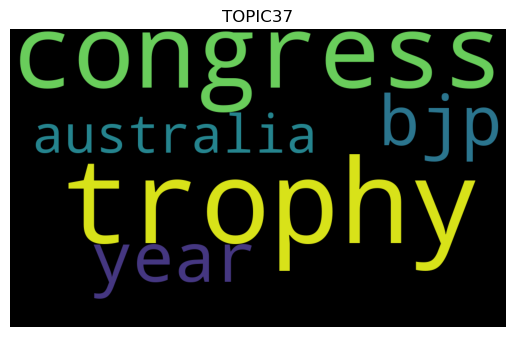

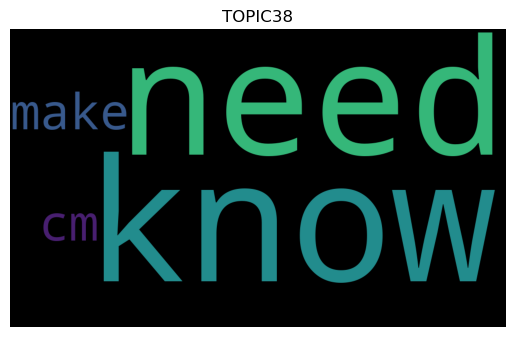

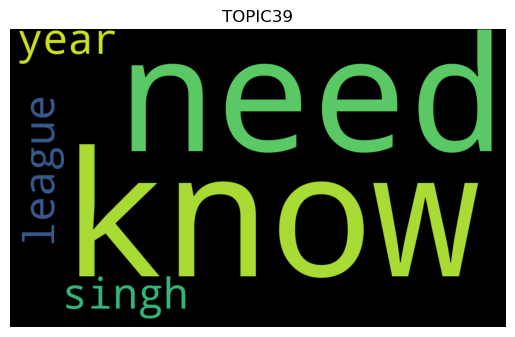

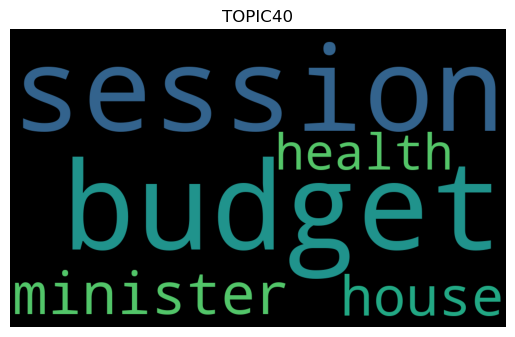

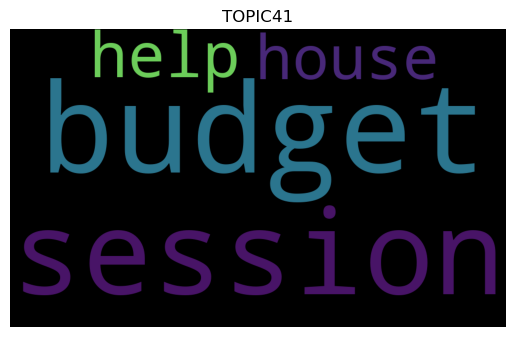

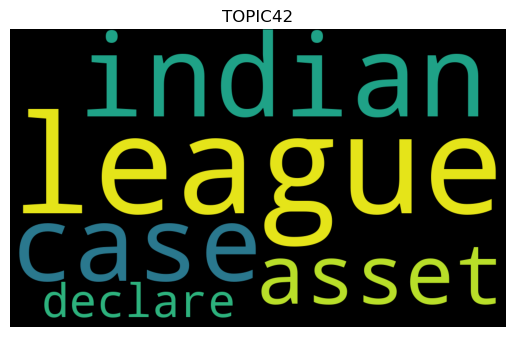

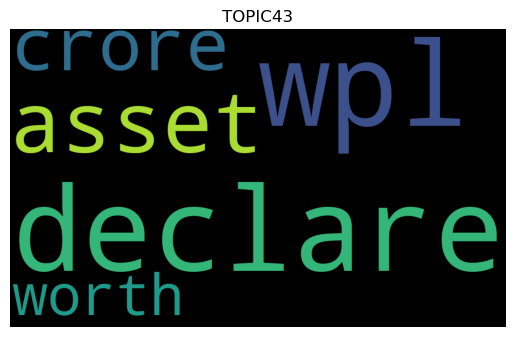

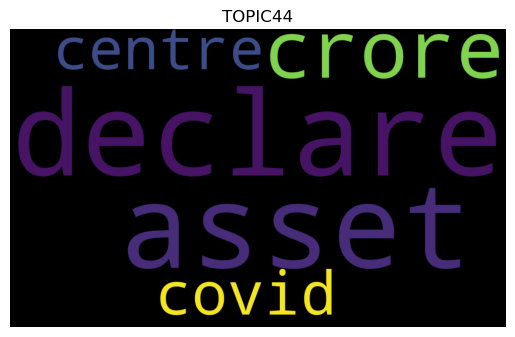

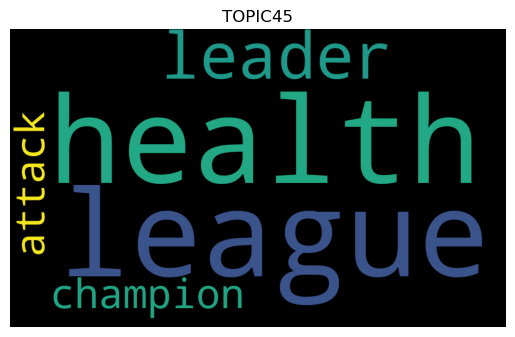

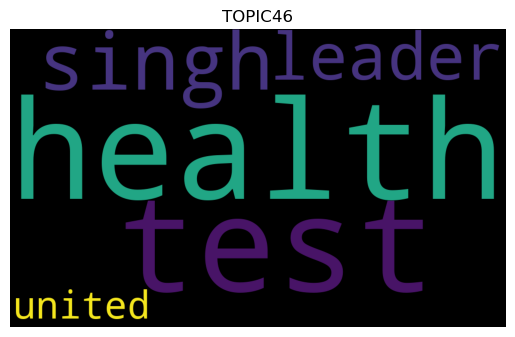

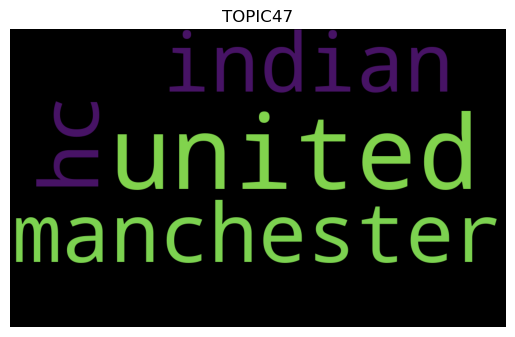

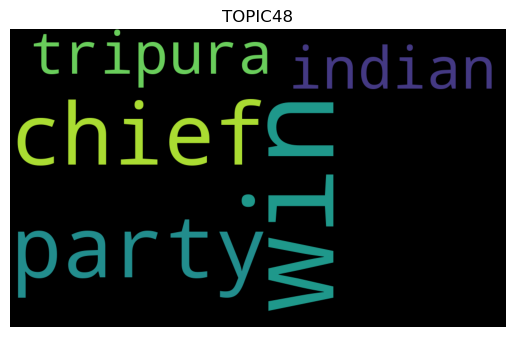

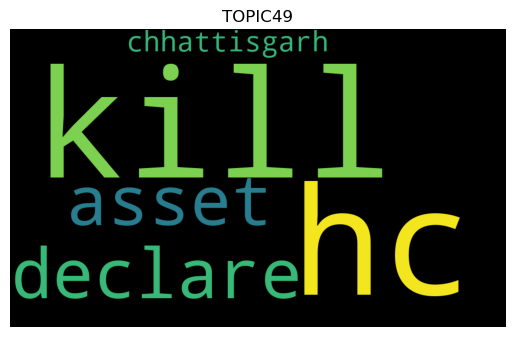

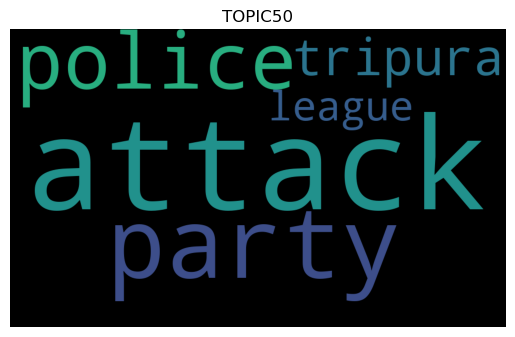

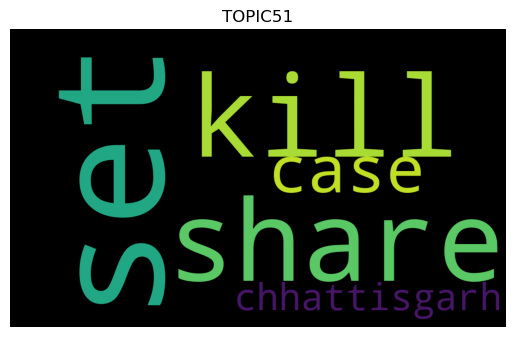

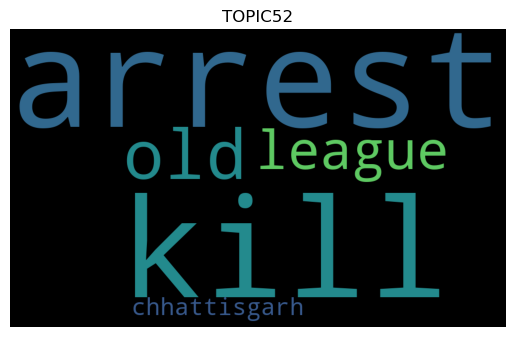

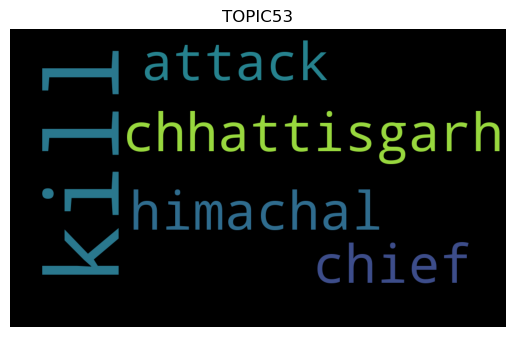

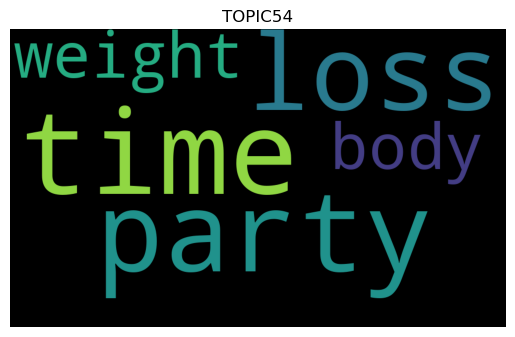

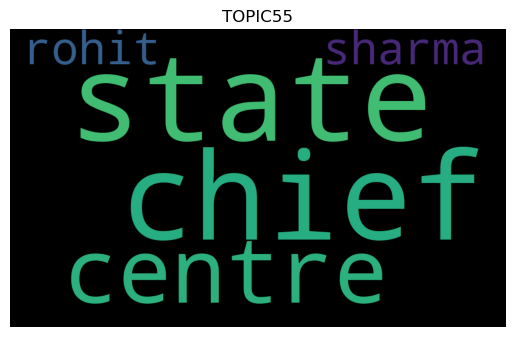

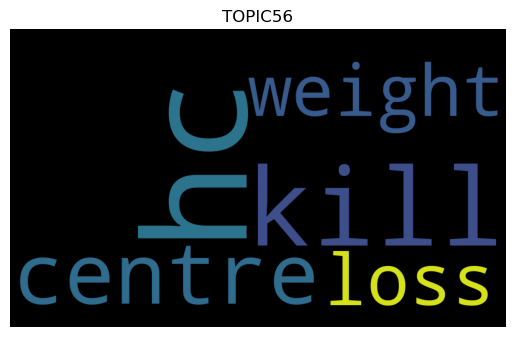

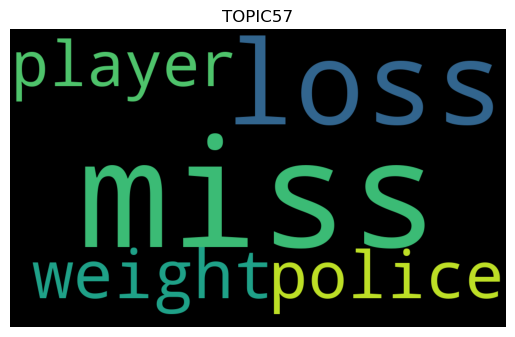

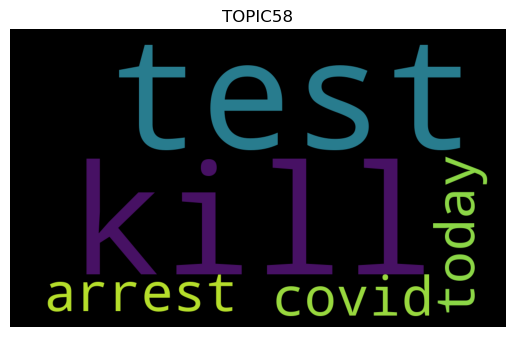

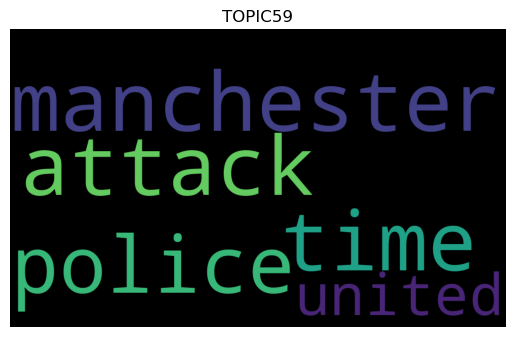

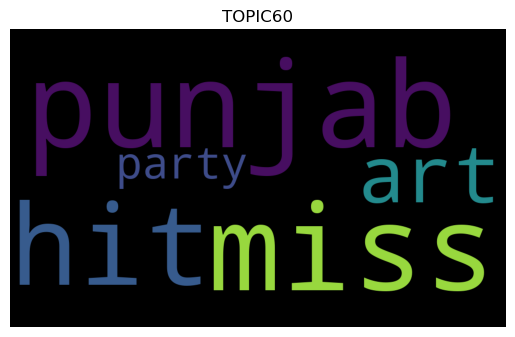

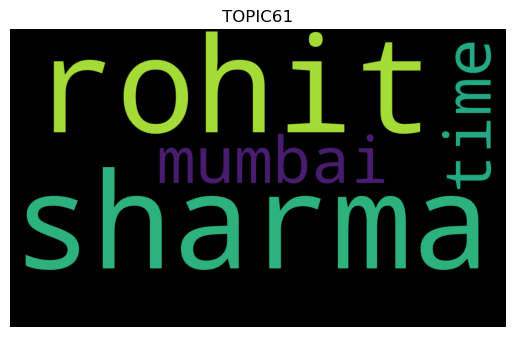

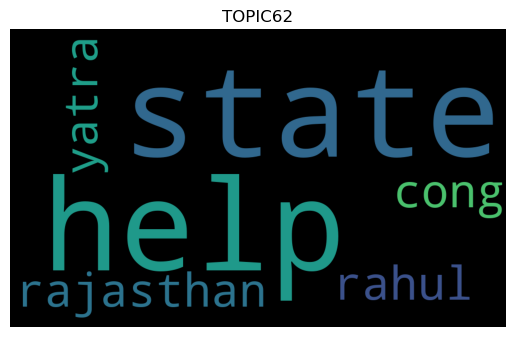

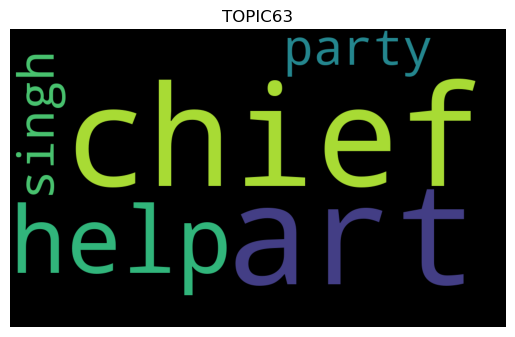

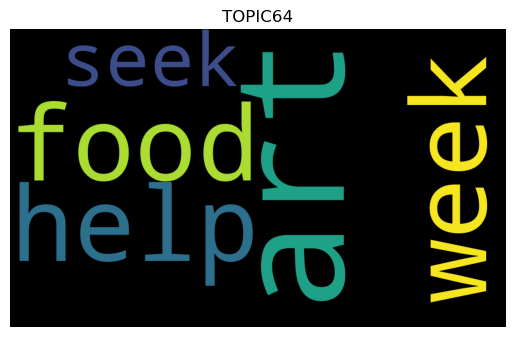

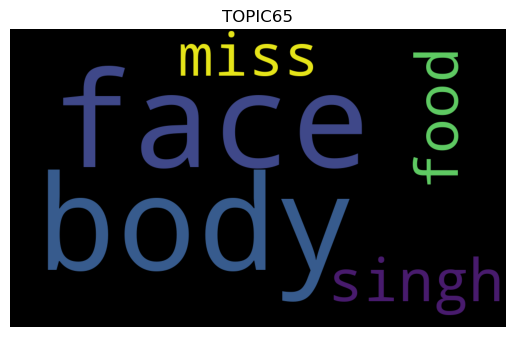

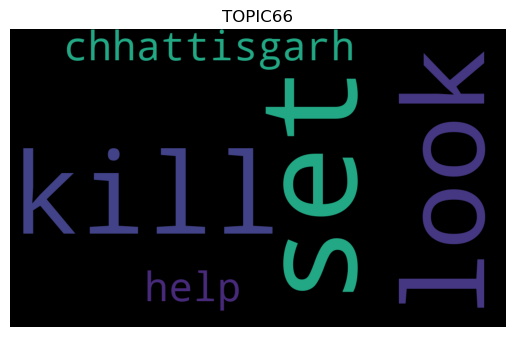

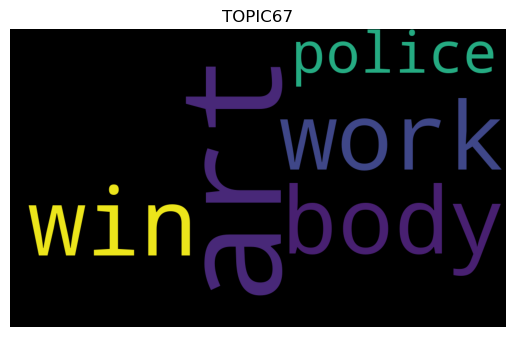

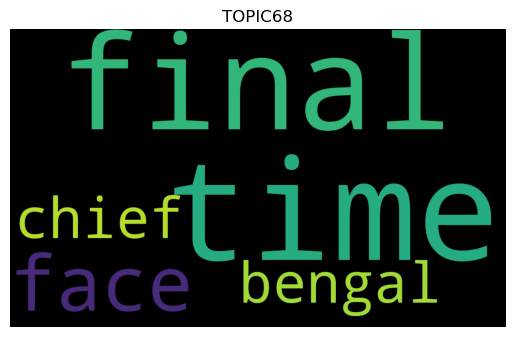

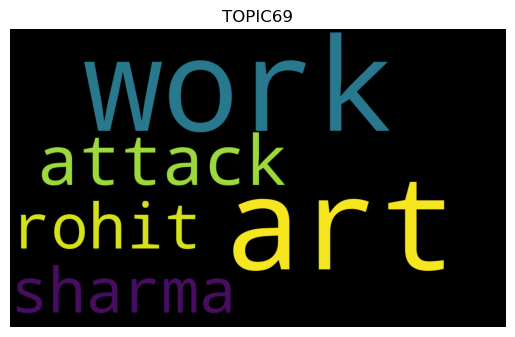

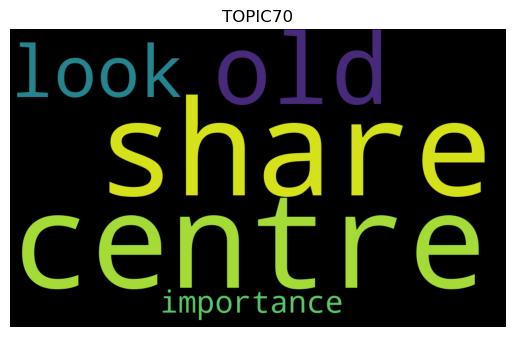

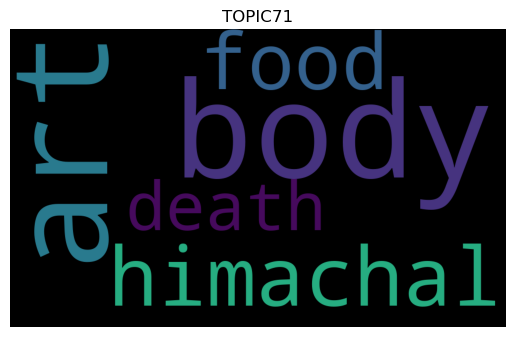

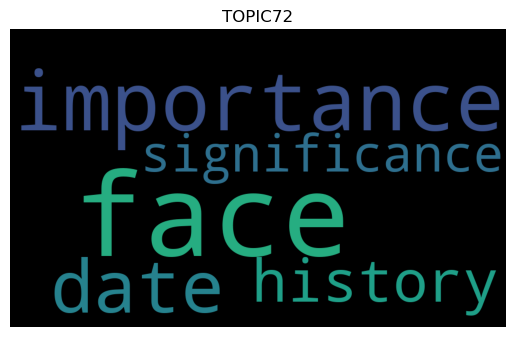

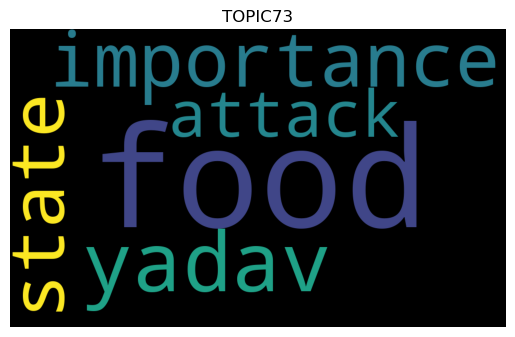

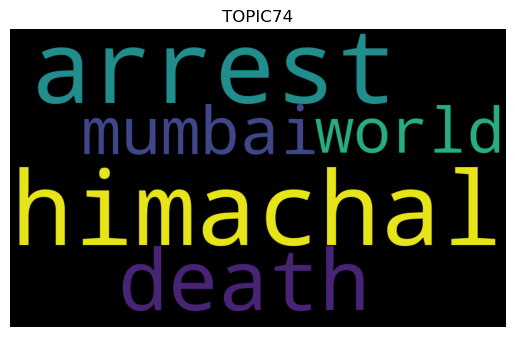

KeyboardInterrupt: 

In [77]:
terms =  vectorizer.get_feature_names_out()
C
for index, component in enumerate(svd_modeling.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(' '.join(top_terms_list))
    plt.imshow(wc)
    plt.title(f"TOPIC{index+1}")
    plt.axis("off")
    plt.show()
    if(index==100):
        break

## UNIGRAM SVD

In [46]:
svd_modeling1= TruncatedSVD(n_components=7500, algorithm='randomized', n_iter=1, random_state=42)
for i in tqdm(range(1)):
    lsa1 = svd_modeling1.fit_transform(tfidf_matrix1)
components1=svd_modeling1.components_
vocab1 = vectorizer1.get_feature_names()

100%|██████████| 1/1 [04:58<00:00, 298.37s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
svd_modeling1.explained_variance_ratio_

array([2.31977974e-03, 3.85262742e-03, 3.25188498e-03, ...,
       3.58274159e-06, 3.56773129e-06, 3.53248166e-06])

In [48]:
svd_modeling1.explained_variance_ratio_.sum()

0.9983233054034975

In [49]:
print("No of components for 0.75 variance: ", select_n_components(svd_modeling1.explained_variance_ratio_, 0.75))
Sigma1 = svd_modeling1.singular_values_
V_T1 = svd_modeling1.components_.T

No of components for 0.75 variance:  2063


<AxesSubplot:>

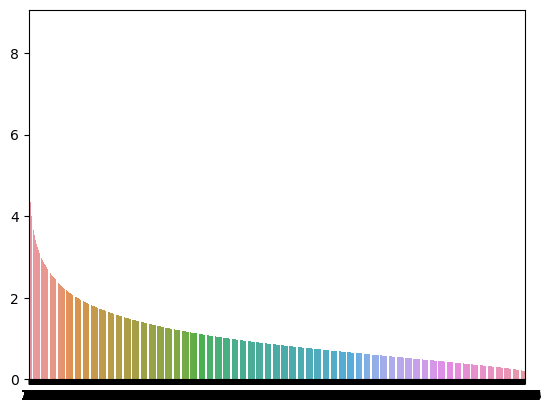

In [50]:
sns.barplot(x=list(range(len(Sigma1))), y = Sigma1)

## TOPICS FORMED WITH SVD (UNIGRAM)

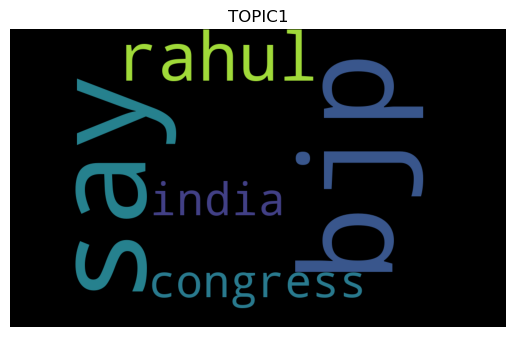

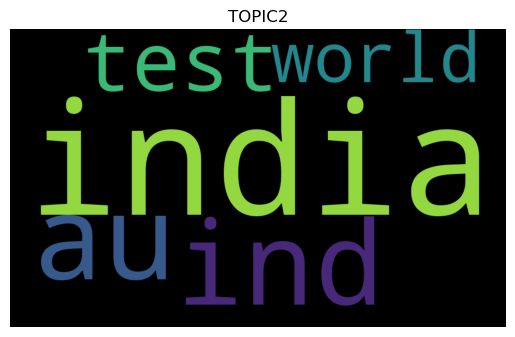

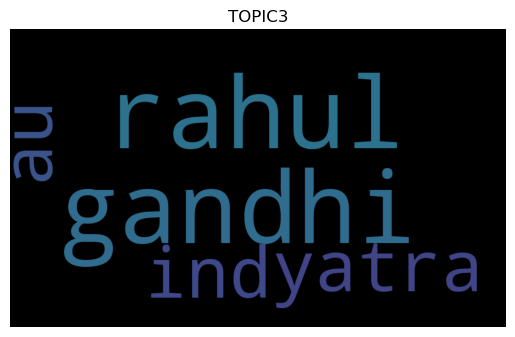

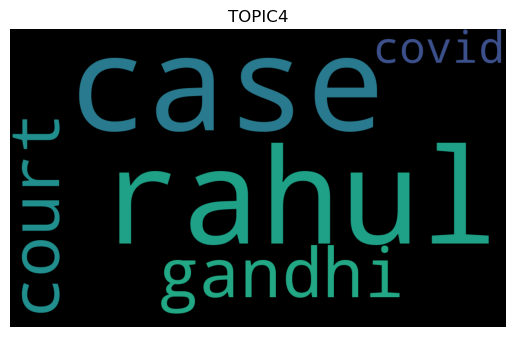

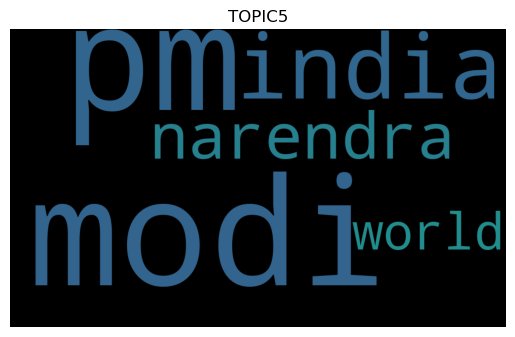

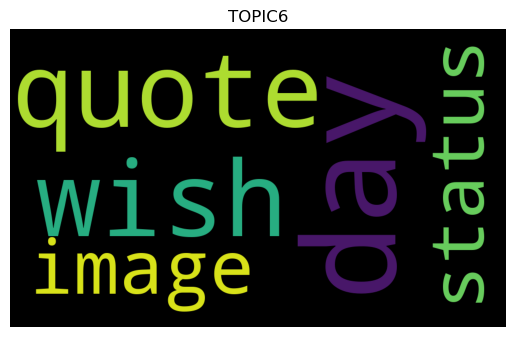

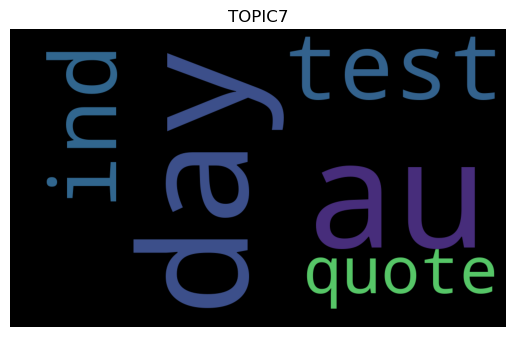

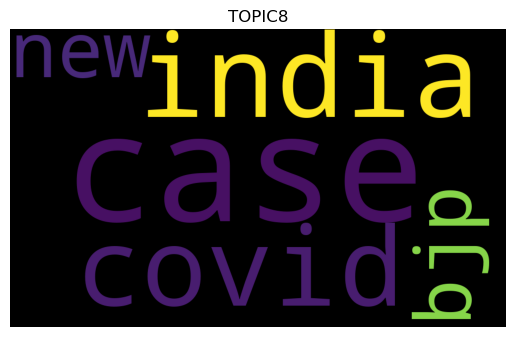

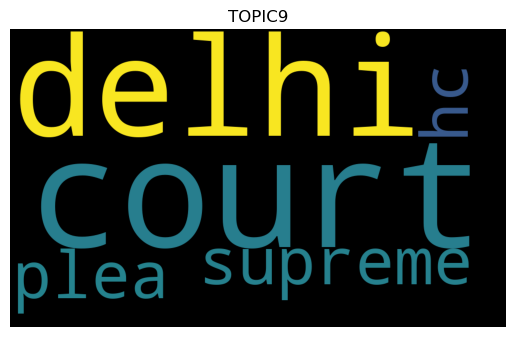

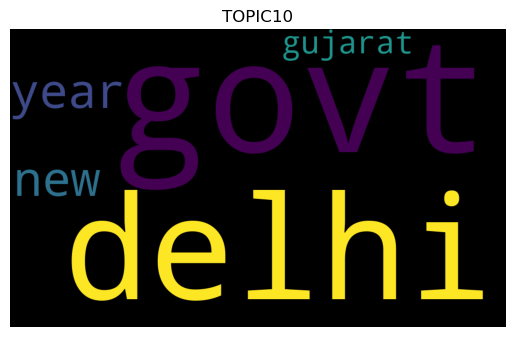

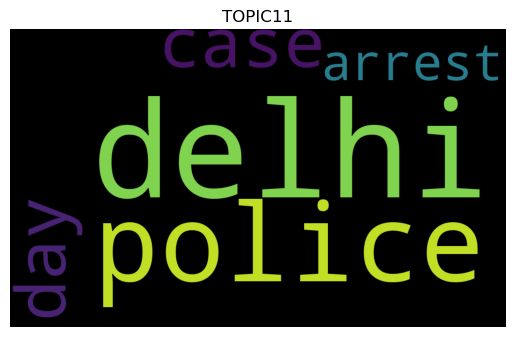

In [79]:
terms =  vectorizer1.get_feature_names_out()

for index, component in enumerate(svd_modeling1.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(' '.join(top_terms_list))
    plt.imshow(wc)
    plt.title(f"TOPIC{index+1}")
    plt.axis("off")
    plt.show()    
    if(index==10):
        break

# PERFORMANCE MEASURE

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay, classification_report

def calculate_confusion_matrix(predicted_labels, true_labels):
    # Calculate confusion matrix
    num_classes = 2
    confusion_mat = np.zeros((num_classes, num_classes))
    for i in range(len(predicted_labels)):
        confusion_mat[true_labels[i]][predicted_labels[i]] += 1
    return confusion_mat

def calculate_accuracy(predicted_labels, true_labels):
    # Calculate accuracy
    return np.sum(np.array(predicted_labels) == np.array(true_labels)) / len(true_labels)

def calculate_precision_recall_f1(predicted_labels, true_labels):
    # Calculate precision, recall, and F1 score
    tp = fp = fn = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == 1 and true_labels[i] == 1:
            tp += 1
        elif predicted_labels[i] == 1 and true_labels[i] == 0:
            fp += 1
        elif predicted_labels[i] == 0 and true_labels[i] == 1:
            fn += 1
    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    return precision, recall, f1_score

def calculate_map(predicted_scores, true_labels):
    # Calculate mean average precision
    scores_labels = list(zip(predicted_scores, true_labels))
    sorted_scores_labels = sorted(scores_labels, reverse=True)
    relevant_count = 0
    map_sum = 0.0
    for i in range(len(sorted_scores_labels)):
        if sorted_scores_labels[i][1] == 1:
            relevant_count += 1
            map_sum += relevant_count / (i + 1)
    return map_sum / relevant_count if relevant_count > 0 else 0.0

def cos_pred_label(sims, cutoff):
    label = []
    score = []
    for sim in sims[:10]:
        if(sim[1]>=cutoff):
            label.append(1)
        else:
            label.append(0)
        score.append(sim[1])
    return label, score

In [107]:
from sklearn.metrics.pairwise import cosine_similarity

def query_processing(query):
    query_tokens = generate_tokens(query)
    query_tokens = capture_lemmatization(query_tokens)
    query_res = ' '.join(query_tokens)
    query_vec = vectorizer.transform([query_res])
    query_lsi = svd_modeling.transform(query_vec)
    sims = cosine_similarity(query_lsi, lsa)
    sims = [(i, sim) for i, sim in enumerate(sims[0])]
    sims = sorted(sims, key=lambda item: -item[1])
    print("\n")
    print(sims[:10])
    print("\n")
    
    for sim in sims[:10]:
        print(json.dumps(articles[sim[0]]['heading']))
        bleu.append(json.dumps(articles[sim[0]]['heading']))
    print("\n")
    
    query_vec = vectorizer2.transform([query_res])
    query_lsi = svd_modeling2.transform(query_vec)
    sims = cosine_similarity(query_lsi, lsa2)
    sims = [(i, sim) for i, sim in enumerate(sims[0])]
    sims = sorted(sims, key=lambda item: -item[1])
    print("\n")
    print(sims[:10])
    print("\n")
    
    for sim in sims[:10]:
      print(json.dumps(articles[sim[0]]['heading']))
    print("\n")    
    
    query_vec = vectorizer1.transform([query_res])
    query_lsi = svd_modeling1.transform(query_vec)
    sims = cosine_similarity(query_lsi, lsa1)
    sims = [(i, sim) for i, sim in enumerate(sims[0])]
    sims = sorted(sims, key=lambda item: -item[1])
    print("\n")
    print(sims[:10])
    print("\n")
    
    for sim in sims[:10]:
      print(json.dumps(articles[sim[0]]['heading']))
    print("\n")
    
    return sims

def performance_measure(predicted_labels, true_labels, predicted_scores):
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    accuracy = calculate_accuracy(predicted_labels, true_labels)
    precision, recall, f1_score = calculate_precision_recall_f1(predicted_labels, true_labels)

    cmd = ConfusionMatrixDisplay(confusion_mat)
    cmd.plot()
    plt.show()
    print(classification_report(true_labels, predicted_labels))
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)
    
    print("\n")
    
def overall_performance_measure():
    predicted_labels = []
    true_labels = [1] * 50
    for i in tqdm(range(50)):
        overview = articles[i]['heading']
        sims = query_processing(overview)[0][0]
        if(sims==i):
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    performance_measure(predicted_labels, true_labels, predicted_labels)

In [105]:
# overall_performance_measure()
true_labels = [1] * 10
while(True):
    query = input("Enter the query: ")
    if(query=='' or query=='\n' or query==None):
        break
    sims = query_processing(query)
    predicted_labels, predicted_score = cos_pred_label(sims, 0.25)
    performance_measure(predicted_labels, true_labels, predicted_score)

  0%|          | 0/50 [00:00<?, ?it/s]



[(0, 0.9438654489433072), (600, 0.2834757595839695), (607, 0.2092540224036147), (356, 0.20643223750501088), (562, 0.19696726360198882), (328, 0.1774569606486347), (139, 0.1751560319147867), (224, 0.16594348089856575), (2380, 0.16561861829612487), (357, 0.1499748972053904)]


"Pro-Khalistan actors using gangs, nexus firmed up in jails in India and abroad, NIA says in chargesheet"
"Z-plus security for Ambanis in India as well as abroad: SC"
"Terrorists-gangsters nexus: NIA searches 75 spots in Delhi and 7 states"
"NIA names 12 in chargesheet, says they had links with pro-Khalistan elements"
"In action against alleged terrorist-gangster nexus, NIA arrests six men"
"NIA says Pak drug lord sent heroin, arms shipment for terror in India"
"NIA files chargesheet against PFI members"
"NIA files chargesheet against jailed gangster Lawrence Bishnoi, Goldy Brar, 12 others"
"9 Lankans arrested from Tamil Nadu camp, NIA says involved in smuggling to revive LTTE"
"Hizbul worker channelised funds as

  2%|▏         | 1/50 [00:05<04:25,  5.42s/it]



[(0, 0.7993216336479151), (607, 0.3145591190986954), (562, 0.30151084240689735), (356, 0.2714995655122177), (139, 0.26771964085587346), (224, 0.2471648221651394), (357, 0.2311974786351768), (8688, 0.22421909257800018), (9257, 0.22148460883386903), (1502, 0.220378041834322)]


"Pro-Khalistan actors using gangs, nexus firmed up in jails in India and abroad, NIA says in chargesheet"
"Terrorists-gangsters nexus: NIA searches 75 spots in Delhi and 7 states"
"In action against alleged terrorist-gangster nexus, NIA arrests six men"
"NIA names 12 in chargesheet, says they had links with pro-Khalistan elements"
"NIA files chargesheet against PFI members"
"NIA files chargesheet against jailed gangster Lawrence Bishnoi, Goldy Brar, 12 others"
"Hizbul worker channelised funds as crafts trader: NIA chargesheet"
"Mumbai-based gang using tranquilizers to lift cattle busted, 9 arrested"
"Kanpur trader\u2019s death: 8 jailed cops named in chargesheet"
"NIA files chargesheet against two CPI (Maoist) g

  4%|▍         | 2/50 [00:10<04:06,  5.14s/it]



[(1, 0.6913685054966308), (1427, 0.26913321097643866), (1477, 0.24715485758626862), (1497, 0.2451337495766408), (4505, 0.23516377078569625), (1830, 0.21662304059962328), (11348, 0.2024528821081738), (12113, 0.19601176014542698), (2014, 0.19207787454012443), (1978, 0.19039937214087435)]


"First time in four years, NREGS jobs in Jan-Feb below pre-Covid level"
"Tripura votes on Feb 16; Nagaland, Meghalaya on Feb 27, counting on March 2"
"Assembly Elections 2023 Highlights: Tripura votes on Feb 16, Meghalaya, Nagaland on Feb 27; counting on March 2"
"First Indian intranasal Covid vaccine to be launched on Jan 26"
"#Politics: Congress riled by Modi\u2019s Bali remarks on \u2018pre and post-2014 India\u2019"
"For one year from Jan, Govt makes foodgrains free for 81 crore people"
"You quit your job, but you\u2019re still miserable. Now what?"
"There are still good reasons to avoid catching COVID again \u2013 for one, your risk of long COVID goes up each time"
"Rejuvenation of small rivers 

  6%|▌         | 3/50 [00:15<03:58,  5.07s/it]



[(2, 1.000000000000002), (3052, 0.4351532440542498), (219, 0.42869069302654506), (7756, 0.40920489013814365), (2927, 0.39966041845996175), (4646, 0.3883745305755201), (1229, 0.3871456880356034), (580, 0.3770078845288899), (2922, 0.36405957461487026), (181, 0.3525557044504201)]


"Rahul Gandhi to Lok Sabha Speaker: \u2018Scurrilous, defamatory\u2026 let me respond to BJP\u2019"
"BJP moves to get Rahul Gandhi suspended from Lok Sabha, police send him notice"
"Rahul Gandhi disqualified from Lok Sabha day after conviction"
"BJP protests in all 6 Lok Sabha constituencies in Mumbai, demands apology from Rahul Gandhi"
"To blunt Opposition attacks, BJP takes on Rahul Gandhi in Lok Sabha, demands apology"
"Rahul on Rahul: \u2018I let go of Rahul Gandhi years ago \u2026 He is in your mind, not mine\u2019"
"In Lok Sabha, Rahul Gandhi talks about Adani\u2019s meteoric rise, questions links with PM"
"Lok Sabha Speaker urges all lawmakers to act on cyberbullying"
"BJP demands apology over Rahul Ga

  8%|▊         | 4/50 [00:20<03:53,  5.07s/it]



[(3, 0.9999999999999982), (9538, 0.5165469067013393), (3141, 0.4456995693065467), (2207, 0.40103671878838454), (4040, 0.40093310847997193), (9299, 0.39160406318582913), (584, 0.3757433590851001), (2998, 0.361813285911987), (7847, 0.3539578934293729), (9740, 0.34690714461026034)]


"Assam Class 10 board exam paper leak govt\u2019s failure: CM Himanta Biswa Sarma"
"55:45 Muslim-Hindu arrests in child wedding cases: Assam CM Himanta Biswa Sarma"
"Assam CM Himanta Biswa Sarma now has an input on \u2018correct age of marriage for women\u2019: 22 to 30"
"Defamation suit: Supreme Court dismisses Manish Sisodia\u2019s plea against Assam CM Himanta Biswa Sarma"
"Rise and rise of Himanta Biswa Sarma"
"Assam question paper leak: 3 arrested, 22 detained"
"\u2018Accused has tendered unconditional apology\u2019: Assam CM Himanta Biswa Sarma on Pawan Khera arrest row"
"Guiding BJP campaign before polls, steering it to govt now, Himanta Biswa Sarma is again man of the moment"
"\u2018Karma caught up 

 10%|█         | 5/50 [00:25<03:45,  5.02s/it]



[(4, 1.000000000000002), (315, 0.5201339649456057), (9212, 0.34386336357848357), (2069, 0.33152153500974485), (2122, 0.28775305725746386), (9035, 0.26505147394367956), (9022, 0.25569899049790806), (809, 0.2485708705868977), (923, 0.24806408425231335), (9923, 0.23605651037294917)]


"Minors assaulted, their hair chopped off at Chhattisgarh residential school, eight students booked one sent to jail"
"8 students booked for ragging in Chhattisgarh school"
"10 years on, man gets life in jail for sexually assaulting minor"
"Muslim students most backward academically in Telangana residential schools for minorities: Study"
"Chhattisgarh: 5 more held for assault on cops"
"Noida bungalow owner booked for assaulting minor boy who worked as domestic help"
"Man gets 10 yrs in jail for raping minor"
"EPS booked for assaulting man at airport"
"Chhattisgarh: How mohalla classes and online sessions helped students tide over school shutdown"
"Protests as J&K woman killed, body chopped"




[(5, 0.9760

 12%|█▏        | 6/50 [00:31<03:59,  5.45s/it]



[(5, 0.999999999999998), (93, 0.3944366585258861), (4776, 0.30517061509862553), (2079, 0.2984889771003562), (609, 0.29302640237747307), (2421, 0.2755655248140333), (4615, 0.27388459265245696), (4672, 0.2676383198197496), (2159, 0.26517733734555027), (1944, 0.2577866043767732)]


"Govt nod to acquire defence hardware worth Rs 70,500 crore"
"Defence contracts worth thousands of crores inked before fiscal ends"
"I Hereby Declare: Jagdish Vishwakarma has movable assets worth Rs 8.64 crore"
"Uttarakhand CM inaugurates 26 schemes worth Rs 306 crore"
"Government monetised enemy properties worth Rs 3,400 crore"
"Defence ministry approves capital procurement proposals worth Rs 84,328 cr"
"As BJP looks to acquire its third \u2018Lal\u2019 in Haryana, could Congress leader Kiran Choudhry be headed there?"
"I Hereby Declare: Purshottam Solanki lists liabilities worth Rs 8.93 crore"
"Electoral bonds worth Rs 232.10 crore sold in December, 83% redeemed in Delhi"
"Green hydrogen mission gets Cabine

 14%|█▍        | 7/50 [00:37<03:53,  5.44s/it]



[(6, 1.0), (3448, 0.27201756162153906), (3733, 0.23713315826437328), (6631, 0.23577675525800695), (4360, 0.22460505782550524), (270, 0.2134253065231207), (1060, 0.1993794724740463), (7590, 0.19150383710949573), (833, 0.1858731659007905), (2862, 0.18106363187151892)]


"\u2018Rigid stance\u2019: RS Chairman Dhankhar\u2019s meeting with ministers, Oppn leaders fails to break House impasse"
"When Jagdeep Dhankhar presides over a House"
"One leader\u2019s Vipassana is another leader\u2019s \u2018leisure break\u2019"
"India agar aankhe dikha raha hain, then they have made themselves that strong: Shahid Afridi on BCCI\u2019s rigid stance on Indian team not touring Pakistan for Asia Cup"
"Punjab parties\u2019 silence over Zira stir \u2018deafening\u2019 as AAP govt moves to break impasse after 5 months"
"Opposition blames govt for impasse in Parliament"
"Video of Jaya Bachchan pointing finger at RS Chairman Jagdeep Dhankhar in Parliament goes viral; BJP leaders condemn"
"Held 150 meetings w

 16%|█▌        | 8/50 [00:42<03:42,  5.29s/it]



[(7, 1.0000000000000036), (139, 0.5369650750649934), (2026, 0.4226939225223481), (1432, 0.37946676607507), (35, 0.3721878838485386), (356, 0.3036573219937481), (357, 0.2921622398257446), (1670, 0.28029394081789555), (1502, 0.2787305191845162), (5850, 0.27188820800111774)]


"PFI recruits underwent 3-stage training programme: NIA chargesheet"
"NIA files chargesheet against PFI members"
"Kerala lawyer held for training PFI hit squad: NIA"
"NIA arrests PFI worker in Kerala"
"Protected witness revealed PFI plans to \u2018wage war\u2019 on govt: NIA chargesheet"
"NIA names 12 in chargesheet, says they had links with pro-Khalistan elements"
"Hizbul worker channelised funds as crafts trader: NIA chargesheet"
"NIA: PFI killer squad murdered BJP youth leader in Karnataka"
"NIA files chargesheet against two CPI (Maoist) ground workers"
"Grassroots Programme: HI\u2019s specialised drag-flick and goalkeeping training for U-16 players"




[(8, 0.973474349227155), (7344, 0.30793440408923395), (35

 18%|█▊        | 9/50 [00:46<03:32,  5.19s/it]



[(8, 0.9365660565069935), (2683, 0.3882540655664967), (1496, 0.3405090535439849), (7344, 0.29038374078617063), (8438, 0.2635476469848645), (3925, 0.2578002990450814), (3154, 0.25445724763926686), (9749, 0.2532125970709496), (1540, 0.24439970947868497), (7057, 0.2426410397346147)]


"J&K leaders meet EC, ask for Assembly elections to be announced"
"J&K Opposition parties to meet national leaders, EC to seek statehood, early Assembly polls"
"EC to host international meet on use of tech, election integrity"
"Ahead of Assembly elections, poster of biopic on Siddaramaiah-\u2018Leader Ramaiah\u2019 released"
"Bill to set  up Goseva Ayog moved in Assembly"
"Tripura polls 2023: Ahead of election, TIPRA Motha applies to EC for registration"
"Tripura Assembly polls: BJP, IPFT pull off a surprise, announce last-minute tie-up"
"People have trusted poll results, still EC gives \u2018agnipariksha\u2019 after every election: CEC Kumar"
"EC\u2019s international conference on election integrity to co

 20%|██        | 10/50 [00:52<03:25,  5.14s/it]



[(9, 0.9999999999999994), (7962, 0.2966244139152407), (8277, 0.28001135708381647), (472, 0.25970390688645434), (2400, 0.25908765217069085), (1698, 0.22134714703577096), (12355, 0.2102510939082265), (8594, 0.19650726531005364), (8395, 0.19077123881553518), (9226, 0.18823630477213874)]


"Amritpal Singh still on the run: Centre asks BSF, SSB to be alert at border posts"
"After India alert, Nepal puts Amritpal Singh on surveillance list"
"Amritpal Singh still on run; cops question wife, mother"
"10% reservation for ex-Agniveers in BSF recruitment, Centre issues notification"
"Centre sounds Covid alert, asks states to track positive samples"
"BSF launches mobile app to book tickets for Wagah border retreat ceremony parade"
"Zodiac Alert: What\u2019s in store for Sagittarius in 2022?"
"Avtar Singh Khanda, who targeted Indian mission in UK, \u2018groomed\u2019 Amritpal"
"Amritpal Singh was in Haryana, woman who gave shelter arrested: Police"
"Amritpal still on the run, four close aides arr

 22%|██▏       | 11/50 [00:57<03:18,  5.10s/it]



[(10, 0.9999999999999986), (9881, 0.3536036044207254), (7748, 0.35152811423328734), (7509, 0.3498397687835663), (7979, 0.2803043315962863), (7713, 0.2698611471908259), (6221, 0.26236476045708185), (9223, 0.26182709250363007), (8883, 0.24959750374272757), (7777, 0.24200035732697409)]


"7th Pay Commission: Govt hikes DA by 4%, jute MSP by Rs 300"
"DA hike demand: Delegation of govt employees meets Governor"
"BJP, TMC trade barbs over DA hike"
"Govt employees \u2018attacked\u2019 during protest to seek DA hike; FIR lodged"
"DA Hike: Govt employees\u2019 forum to protest at Delhi\u2019s Jantar Mantar on Apr 10"
"DA hike demand: Suvendu joins protesting govt employees, takes \u2018queen of thieves\u2019 jibe at CM Mamata"
"Sayantan Das becomes India\u2019s 81st Grandmaster"
"Karnataka transport unions call off strike; agree to 15% pay hike"
"Karnataka transport workers to go on indefinite stir from March 21, decline govt\u2019s pay hike offer"
"Gujarat Information Commission suggests to 

 24%|██▍       | 12/50 [01:02<03:12,  5.07s/it]



[(11, 0.9999999999999988), (9010, 0.4365645665667064), (8812, 0.24404003267078409), (8648, 0.2142633011906707), (153, 0.21260081540955034), (3789, 0.19740447063168032), (7599, 0.19539349393355074), (1046, 0.19297894723361256), (2542, 0.18858088080337018), (3282, 0.18763234818739233)]


"1,142 hectares set aside in Navsari PM Modi announces mega textile parks in Gujarat, six states"
"Mega textile park to come up in Lucknow at Rs 1,200 crore: Govt"
"180 hectares of forest land given to industries in 2 years, says Gujarat govt"
"Textile Commissionerate not being shifted out of Mumbai: Fadnavis"
"Uttarakhand Budget sets aside Rs 1,000 crore for work in subsidence-hit areas"
"After PM\u2019s directive, BJP plans mega minority outreach: 60 Lok Sabha seats in focus"
"Gujarat: CAG finds 117 hectares of mangroves destroyed in Kutch; asks govt to save \u2018Kharai\u201d breed of camels from extinction"
"Rs 600 crore set aside for Prasar Bharati revamp"
"PM Modi seeks full majority in Karnataka

 26%|██▌       | 13/50 [01:06<03:06,  5.03s/it]



[(12, 1.0000000000000009), (360, 0.30093534465355637), (9409, 0.2872283836318901), (2272, 0.26854981381350723), (7454, 0.2372508515614305), (526, 0.23636063431674842), (1168, 0.233736850491875), (536, 0.2173891889291367), (1785, 0.21467051712138466), (291, 0.21113443286696118)]


"Worst message from parliamentary democracy is approval to budget without discussion: P Chidambaram"
"Allocate 1% of Union Budget to MEA: Parliamentary panel"
"Metro for Chandigarh tricity gets in-principle approval"
"Chidambaram on India-China clash: Rajnath\u2019s statement was empty, House discussion was desirable"
"MCD Budget discussion today; House adjourned in 3 minutes"
"Long live anonymous democracy: Chidambaram\u2019s dig at electoral bond donations to BJP"
"Budget discussion: DMK says making 2G remarks does not behove PM"
"Parliamentary panel to seek explanation from 13 opposition MPs for disrupting RS proceedings during Budget Sessions\u2019 first leg"
"Demonetisation decision gets Supreme Court s

 28%|██▊       | 14/50 [01:13<03:18,  5.51s/it]



[(13, 0.9173116304580885), (1084, 0.4153769135894136), (1385, 0.3971221809164045), (2172, 0.33122013695127156), (336, 0.32950784130245836), (2054, 0.312190333584254), (1250, 0.31153356899970713), (9810, 0.3041351268227084), (1657, 0.2895483569800035), (2162, 0.28904229713141943)]


"Air India and Nepal Airlines aircraft almost collided mid-air; 3 air traffic controllers suspended"
"Aero India: US Air Force\u2019s F-35 debuts at Yelahanka Air Force Station"
"Lessor says Air India to order around 500 jets"
"Passenger finds stone in Air India in-flight meal; airline says strict action will be taken against caterer"
"Air India urination case: woman moves SC, appeals DGCA, airlines for SOPs to check misconduct"
"Air India urination incident: DGCA terms conduct of airline \u2018unprofessional\u2019, serves notices to officials, crew"
"Air India seals record order for about 500 jets from Airbus, Boeing: Report"
"Air hostess falls to death from highrise in Bengaluru"
"Air India \u2018urinati

 30%|███       | 15/50 [01:23<03:58,  6.82s/it]



[(14, 0.9999999999999994), (3843, 0.3156308051128785), (8001, 0.2949954296982033), (10993, 0.26573214390540567), (11614, 0.24718734134227754), (10397, 0.2407958407563161), (2493, 0.22415626916666453), (2393, 0.21760827107269712), (7257, 0.21347932745858966), (3795, 0.21012259393962013)]


"Kerala will continue to stick to 5 years as Class 1 admission age: Minister Sivankutty"
"Factionalism in Telangana Cong continues to simmer as feuding sides stick to their stand"
"After 3-year gap, DU student union election to be held after admissions this year"
"New year resolutions: why your brain isn\u2019t wired to stick to them \u2013 and what to do instead"
"How do you deal with school admissions anxiety"
"One night without sleep can age your brain by these many years"
"Dialogue with Christians to continue, open for talks with Muslims in Kerala: RSS"
"Age of adolescence \u2018risky\u2019, full maturity not at 18 but attained at 25: Kerala varsity to HC"
"Pakistan first class cricketer Asif Af

 32%|███▏      | 16/50 [01:28<03:35,  6.33s/it]



[(15, 0.8803135026297143), (976, 0.2811537122003963), (235, 0.2752514561421912), (8739, 0.2605530701963978), (3897, 0.24880285807369193), (4286, 0.21549245910107953), (12340, 0.2139819753652366), (7776, 0.2099639170047205), (10102, 0.19888822948852197), (11518, 0.19770434543780394)]


"IGNCA launches Vedic Heritage Portal with 550 hours of audio-visual content"
"From March, broadcast 15 hours of monthly national interest content: Govt to channels"
"Jharkhand govt launches job portal to ensure 75% local quota in pvt sector"
"Shraddha Walkar audio tapes: \u2018(Aaftab) will hunt me down, try to kill me\u2019"
"BJP denies claims in \u2018leaked audio tape of MLC\u2019"
"In Telangana, land records portal the site of latest Congress-TRS battle"
"\u2018The Hours\u2019 gets dressed for the opera"
"Protest against move to cut over 300 \u2018heritage\u2019 trees"
"36 hours in Taipei, Taiwan"
"Healthy eating: Some plant foods and their protein content"




[(16, 0.9999999999999977), (1578, 0.2

 34%|███▍      | 17/50 [01:33<03:15,  5.92s/it]



[(16, 1.0000000000000004), (1216, 0.2821955704055142), (1765, 0.27941779530655814), (1123, 0.27161050948747006), (11730, 0.2649736347325988), (3778, 0.25841250056431225), (12185, 0.25725173660771306), (4675, 0.2559100692857369), (2894, 0.2458174952501924), (2087, 0.24575491076210582)]


"India had idea of elected leaders long before others: PM Modi"
"Apsara Iyer becomes first Indian-American student to be elected president of Harvard Law Review"
"You are trailblazer for New India: PM Modi to NCC cadets"
"Chidambaram says half of CWC should be elected as per Cong constitution; bats for younger leaders\u2019 inclusion"
"All about the world\u2019s longest river cruise that PM Narendra Modi will flag off on January 13"
"Idea of separatism can\u2019t be confiscated or jailed: PDP"
"How physios and occupational therapists are helping long Covid sufferers"
"BJP\u2019s 7-time winner from Gujarat\u2019s Dwarka says not elected, \u2018but selected by all\u2019"
"#Politics | \u2018Nari Shakti f

 36%|███▌      | 18/50 [01:38<03:00,  5.64s/it]



[(17, 0.9999999999999998), (520, 0.39335479889822367), (462, 0.2566154754910073), (827, 0.24961743825599658), (6170, 0.23882377372041716), (3282, 0.21485080911057605), (28, 0.1903415639506908), (2227, 0.18537782811503511), (907, 0.17715946166186597), (23, 0.17691164526588224)]


"Respect sovereignty, seek no unilateral military superiority: Doval to SCO members"
"Australia\u2019s respect for India\u2019s sovereignty unwavering: Envoy"
"\u2018Terrorism among most serious threats to international peace\u2019: NSA Ajit Doval addresses SCO meet in Delhi"
"Supreme Court to host 3-day meeting of Chief Justices of SCO member states"
"\u2018If you respect the pitch and play accordingly, the pitch will also respect you\u2019: R Ashwin"
"Mohan Bhagwat: There is no caste superiority, illusion has to be set aside"
"IAF now has 39 of 53 military airfields, nine ALGs for civil use"
"Private member Bill seeks PM-led panel for selecting Chief Election Commissioner"
"Doval meets Sullivan, says need t

 38%|███▊      | 19/50 [01:43<02:48,  5.44s/it]



[(18, 0.999999999999995), (254, 0.4380625800523761), (4204, 0.39270080226350346), (1501, 0.3685208385954886), (2498, 0.3394819647696476), (1799, 0.3110901409979266), (1344, 0.30819190183285095), (7381, 0.30725168317866125), (1521, 0.297217407361868), (747, 0.28232844936904167)]


"Over 300 lawyers ask Kiren Rijiju to withdraw comments against retired judges"
"A few retired judges part of \u2018anti-India gang\u2019 trying to turn judiciary against government: Kiren Rijiju"
"Kiren Rijiju: Insider, Outsider"
"Rijiju backs retired High Court judge who said Supreme Court has \u2018hijacked\u2019 Constitution"
"Kiren Rijiju draws flak for remark on judges: \u2018Law Minister talking like an outlaw\u2019"
"Under Modi govt, there are no two ways about following the Constitution: Kiren Rijiju"
"Centre vs Collegium: Kiren Rijiju shares former Delhi HC judge\u2019s interview to highlight \u2018sane\u2019 view"
"SC collegium elevates 2 Gujarat lawyers as HC judges"
"Judges don\u2019t have to fa

 40%|████      | 20/50 [01:48<02:39,  5.31s/it]



[(19, 0.9999999999999991), (9182, 0.2950897492845309), (1977, 0.2903844322686759), (10668, 0.25620341439161504), (1745, 0.22623509015848392), (83, 0.2178707576808619), (463, 0.20920714984246205), (1327, 0.19879305214336904), (7734, 0.1926685343032513), (1017, 0.19251127281157293)]


"Two pilots killed after Army\u2019s Cheetah helicopter crashes near Arunachal\u2019s Bomdila; probe ordered"
"Gujarat trainee pilot, instructor killed in MP aircraft crash"
"Rajnath in Arunachal: Indian Army can face any challenge on border"
"Can antiperspirants and deodorants kill you?"
"Sukhoi-Mirage crash: Eyewitnesses recount blast-like sound, fire raining from sky, two pilots landing in nearby thicket"
"In Arunachal, an English lesson for \u2018students\u2019 above 50"
"Namibian cheetah Siyaya gives birth to four cubs, first cheetahs to be born on Indian soil in over 70 years"
"12 South African cheetahs to land in India on February 18, join 8 Namibian cheetahs at Kuno National Park"
"Video of youths

 42%|████▏     | 21/50 [01:53<02:31,  5.22s/it]



[(20, 0.9591240764830307), (3483, 0.2907192347349742), (2412, 0.27673304705947555), (2718, 0.27308177029866704), (2043, 0.2613141790581029), (2319, 0.2576264114966205), (3790, 0.25279775308045843), (3430, 0.24771249089751657), (1229, 0.23993540215367268), (66, 0.2382487758174623)]


"YouTube \u2018looking into\u2019 Congress claim that Rahul Gandhi\u2019s Adani videos\u2019 viewership suppressed"
"4 things Rahul Gandhi said in Parliament about Adani Group"
"BJP\u2019s Amit Malviya claims ex-minister tied Rahul Gandhi\u2019s laces; Congress says \u2018fake news\u2019"
"PM could have simply said no links with Adani: Rahul at Congress plenary"
"Rahul Gandhi Bharat Jodo Yatra Highlights: In Panipat, Rahul Gandhi targets BJP over Agnipath scheme, claims youth were threatened against protesting"
"Congress not a fascist party, open to discussion: Rahul Gandhi"
"Pakistani OTT app, YouTube videos, now BBC film: How Centre has wielded IT Rules emergency powers"
"Modi shell-shocked, did not giv

 44%|████▍     | 22/50 [01:58<02:24,  5.15s/it]



[(21, 0.9999999999999992), (2337, 0.5277506931350239), (2448, 0.4289305003277995), (299, 0.3201347363342074), (2145, 0.3026761362917371), (2326, 0.2744624867615003), (1354, 0.24765022079011023), (9579, 0.23705001082698904), (848, 0.228664816019069), (1811, 0.2218779067739434)]


"French visa fraud mastermind escaped from India: CBI"
"CBI files FIR against 6 over \u2018visa fraud\u2019"
"Visa Fraud: Files of 64 people with high risk of migration \u2018disappear\u2019 from French Embassy"
"H-1B visa: Laid-off workers in US get B1/B2 cushion"
"Unitech, former directors booked by CBI for fresh fraud of Rs. 395 cr"
"CBI registers 3 more fraud cases against Mehul Choksi"
"CBI books Navy personnel among 31 for income tax fraud in Kerala"
"Arvind Kejriwal the liquor mastermind, says BJP as it steps up attack"
"US to issue one million visas to Indians this year"
"PM backs down, escapes when people stand up to him: Rahul Gandhi"




[(22, 0.9999999999999988), (2253, 0.2175152945774768), (2067,

 46%|████▌     | 23/50 [02:03<02:17,  5.09s/it]



[(22, 1.0000000000000009), (2067, 0.29968827397055736), (948, 0.2639108691292877), (8237, 0.2600524214441302), (2436, 0.2600086894564425), (2253, 0.25956556324946145), (3326, 0.25909122469822277), (3270, 0.2525831778988287), (8541, 0.24283813877662067), (6411, 0.24153892338297592)]


"Supreme Court questions Guv\u2019s role in Maharashtra crisis: Top 5 points"
"Joshimath crisis: No urgent hearing, Supreme Court lists case for January 16"
"Supreme Court Collegium recommends CJs for 5 High Courts"
"Maharashtra farming crisis far from over as untimely rains with hailstorms loom"
"5 times the Supreme Court upheld the rights of women in 2022"
"Justice Dipankar Datta sworn-in as Supreme Court judge"
"Dhami draws fire for lurching from crisis to crisis:\u00a0Anti-cheating law to Joshimath to Ankita case"
"Maharashtra Cong crisis far from over, party sends leader to take stock"
"SYL canal: Supreme Court tells Centre to play more \u2018pro-active role\u2019 to resolve dispute"
"FIFA faces que

 48%|████▊     | 24/50 [02:08<02:11,  5.06s/it]



[(23, 1.0000000000000016), (1579, 0.3878242422724387), (34, 0.32858963211066006), (237, 0.31774238891954), (837, 0.28868417014932785), (669, 0.2859948715675013), (707, 0.26270619634929754), (5035, 0.24952637460492308), (1892, 0.2459169830850178), (462, 0.24256760589981624)]


"India invites Pakistan Defence minister for SCO meet"
"Days after Shehbaz Sharif signal, India invites Pakistan\u2019s Foreign Minister"
"SCO Buddhist heritage meet starts today"
"India moots action plan to mark 2023 as year of tourism development at SCO meet"
"After asking for link to join virtually, Pakistan delegation skips SCO meeting of Chief Justices hosted by India"
"SCO Chief Justices\u2019 meet begins, Pak attends online"
"G20 Foreign Ministers\u2019 Meet: Minister Jaishankar meets UK Foreign Secretary James Cleverly"
"India can play Pakistan at a neutral venue during Asia Cup: Pakistan Cricket Board\u2019s proposal"
"India\u2019s presidencies in SCO, G20 will strengthen world stability and security: P

 50%|█████     | 25/50 [02:13<02:06,  5.05s/it]



[(24, 0.7871021225467879), (455, 0.2174754464411417), (4541, 0.20095355544808105), (1977, 0.20043312536401445), (2347, 0.18965770523611106), (8316, 0.18226533861872668), (8632, 0.18226533861872668), (2342, 0.18198785299081843), (7411, 0.18071176234997838), (3438, 0.17672199317601278)]


"Environmental clearances, land acquisitions: Rajnath chairs high-level meet to review infra development along northern borders"
"Indo-African ties in focus: Rajnath Singh links security, development"
"Parties face rebellion in 4 Kullu seats as people grouse about land acquisition, road projects"
"Rajnath in Arunachal: Indian Army can face any challenge on border"
"PM doesn\u2019t utter \u2018China\u2019, he and not Rajnath Singh must answer on border issue in Parliament: Cong"
"Status quo maintained with China on LAC, talks on at different levels: Northern Army Commander"
"Status quo maintained with China on LAC, talks on at different levels: Northern Army Commander"
"On path to becoming superpower, 

 52%|█████▏    | 26/50 [02:18<02:00,  5.04s/it]



[(25, 0.9999999999999971), (1970, 0.41660949432469496), (9430, 0.3080786159235618), (1910, 0.2360803601690585), (7436, 0.23593916505779078), (1396, 0.2254270534740991), (8639, 0.21386057632639732), (2560, 0.20639038453802433), (8161, 0.20386543398262796), (8681, 0.19075868001586227)]


"UIDAI makes Aadhaar document update facility online free till June 14"
"Now Aadhaar holders can update addresses online with consent of head of family"
"Submit files, documents related to RLA online now"
"Govt extends free import of tur, urad till March 2024"
"Koregaon Bhima inquiry commission gets another extension till June 30"
"BJP retains Nadda as chief till June next yr; Shah says will get stronger mandate in \u201924"
"Ahmedabad to hold annual Filipinos meet-up on June 11"
"Rajasthan Assembly passes Right to Health Bill: Treatment free now at govt facilities, select private hospitals"
"Health facilities in Mohali to get a Rs 76-crore facelift"
"Right to Service Act: 209 complained of not getting

 54%|█████▍    | 27/50 [02:23<01:56,  5.04s/it]



[(26, 0.9999999999999999), (1774, 0.4941582679303209), (2180, 0.34424876725901105), (1231, 0.2929806526476774), (12129, 0.2698203608130348), (11099, 0.22683108295929577), (693, 0.22667133415521623), (9673, 0.20953289683687684), (1793, 0.20543740579632963), (9605, 0.1993015360680217)]


"DRDO conducts two successful flight tests of VSHORADS missile"
"DAC nod to VSHORAD missile systems being designed by DRDO"
"India carries out successful test launch of Prithvi-II"
"Second development flight successful, SSLV joins Isro\u2019s fleet of three rockets"
"Warren Buffett shares advice to become successful in life"
"What happens to your body on a long-haul flight?"
"Navy test-fires ship-launched version of BrahMos missile"
"India\u2019s high-speed expendable aerial target Abhyas to soon have only one rocket booster: DRDO"
"IAF successfully test fires extended range version of Brahmos missile from SU-30MKI fighter"
"ED conducts searches against Franklin Templeton in Mumbai, Chennai"




[(27, 

 56%|█████▌    | 28/50 [02:28<01:50,  5.02s/it]



[(27, 0.9999999999999987), (444, 0.3883854032746784), (2333, 0.34294311656722454), (4332, 0.334591511486449), (3352, 0.33301678866806655), (2943, 0.3052708295512737), (1283, 0.3050078252794588), (769, 0.29993378434693324), (624, 0.2811266924139587), (168, 0.2760884929751839)]


"Democracy not in peril, Congress brought to political perish: Smriti Irani hits out at Rahul Gandhi"
"BJP sharpens attack on Rahul Gandhi, Smriti Irani says people with PM"
"Modi govt increased honorarium of Anganwadi workers to Rs 4,500: Smriti Irani"
"For comments on Smriti Irani, Congress leader under fire: Who is Ajay Rai?"
"George Soros\u2019s remarks show \u2018desire to break Indian democracy\u2019 and have a \u2018pliable\u2019 govt: Smriti Irani"
"\u2018Policies were made by (Sonia-led) NAC\u2026 Was that democracy?\u2019: RSS attacks Rahul Gandhi"
"Women need to be at centre of decisions for future-ready society: Smriti Irani"
"Modi destroying democracy, says Rahul; BJP hits back"
"BJP slams Rahul G

 58%|█████▊    | 29/50 [02:33<01:45,  5.02s/it]



[(28, 1.0000000000000027), (821, 0.2953845360732216), (2372, 0.25786935795699223), (4067, 0.2522204102224611), (30, 0.2478183001361848), (797, 0.24394012832841835), (9735, 0.23849577615698206), (11322, 0.236762683597268), (637, 0.22699070762670656), (1156, 0.2258272948946949)]


"IAF now has 39 of 53 military airfields, nine ALGs for civil use"
"IAF airlifts 438 stranded passengers between J-K and Ladakh"
"India, Kazakhstan start joint military drill in Meghalaya"
"Behind Uniform Civil Code Bill in Parliament, a perennial protester from Rajasthan"
"Push development, integration of directed energy, hypersonic weapons: IAF Chief"
"IAF inducting in-house system to identify friendly forces in combat"
"Military Digest: Three decades of women officers in Army"
"Should body moisturisers be used on the face?"
"Group Captain Shaliza Dhami first IAF woman officer to head frontline unit"
"Indo-Japan joint military exercise \u2018Ex Dharma Guardian\u2019 from today"




[(29, 0.9597720956323612)

 60%|██████    | 30/50 [02:38<01:40,  5.01s/it]



[(29, 0.9490692533803611), (10668, 0.31840431640237704), (1741, 0.26138821051315336), (8587, 0.2443618499233373), (163, 0.2049643034255467), (7860, 0.19725642508191607), (1831, 0.19564631178585815), (9068, 0.191943995691254), (9622, 0.19042591176739018), (1961, 0.18548644360911526)]


"Next of kin to get Rs 25 lakh if J&K CAPF personnel killed on duty"
"Can antiperspirants and deodorants kill you?"
"Kirti Chakra for three Chhattisgarh police personnel killed in 2021 Maoist encounter"
"8,000 police personnel to be recruited this yr: Sanghavi"
"436 personnel died by suicide in CAPFs in the last 3 years: Government"
"\u2018Regret killing teen\u2019: Man held for killing 3 neighbours to court"
"Magistrates, judge not above law; have to face consequences for dereliction of duty: Kerala HC"
"Negligence by BWSSB personnel leads to blasts at several homes in Bengaluru neighbourhood, 3 injured"
"Ruckus in Kerala Assembly: 4 Opposition MLAs, 5 security personnel injured"
"A topper, she never d

 62%|██████▏   | 31/50 [02:43<01:34,  4.99s/it]



[(30, 0.8960136570312471), (3955, 0.2520533868626963), (6214, 0.24111596636905186), (821, 0.22520916483447967), (28, 0.22205597579661449), (9407, 0.20304655251943463), (104, 0.19278704861449256), (797, 0.18619050326430256), (4508, 0.18436621719325497), (10333, 0.1824806725730879)]


"Push development, integration of directed energy, hypersonic weapons: IAF Chief"
"Adani port back on track, another win for Pinarayi govt\u2019s \u2018development push\u2019"
"India among eight direct qualifiers for Women\u2019s T20 World Cup 2024"
"IAF airlifts 438 stranded passengers between J-K and Ladakh"
"IAF now has 39 of 53 military airfields, nine ALGs for civil use"
"Tamil Nadu woman who made videos wielding weapons arrested"
"India can achieve energy independence by 2047: US study"
"IAF inducting in-house system to identify friendly forces in combat"
"Balkrishna Shukla: \u2018As regards seeking votes in PM\u2019s name, people only think of each BJP candidate as a direct representative of Modiji

 64%|██████▍   | 32/50 [02:48<01:30,  5.00s/it]



[(31, 0.9999999999999974), (9075, 0.5152470868716255), (3367, 0.40438211151685655), (9316, 0.38934440813530263), (7365, 0.3095617776350643), (4533, 0.2859977122281222), (9280, 0.27993589191419416), (630, 0.26911297540780194), (7919, 0.2511669288361929), (8625, 0.23898028036207314)]


"Some private hospitals may start medical colleges this year, says Mandaviya"
"Gujarat to have 43 medical colleges by end of this year, says minister"
"Heated exchange between Union Health Minister Mandaviya, DMK MPs over TN medical colleges"
"Tamil Nadu: Auditorium at Ariyalur medical college named after deceased medical aspirant Anitha"
"Pune: Medical student dies after jumping from terrace of Sassoon Hospital"
"Himachal Pradesh polls \u2013 Ground Report: Chamba hospital has names of stalwarts Nehru and Vajpayee, but voters rue it\u2019s only \u2018naam ka medical college\u2019"
"Two held for cheating man on pretext of providing admission to Delhi medical college"
"New colleges, better salaries for nu

 66%|██████▌   | 33/50 [02:53<01:24,  4.99s/it]



[(32, 1.000000000000002), (2328, 0.5567552542917563), (254, 0.4417537260425207), (71, 0.43539318227496376), (4204, 0.4092448632388203), (1799, 0.37761696024676267), (747, 0.37500722942174997), (2367, 0.3641140838409443), (1534, 0.29054469603771627), (3914, 0.27514150709077306)]


"Govt, judiciary working as team; some actors trying to portray conflict between two: Kiren Rijiju"
"Manish Tewari on Kiren Rijiju remarks: Is govt trying to orchestrate confrontation with judiciary?"
"A few retired judges part of \u2018anti-India gang\u2019 trying to turn judiciary against government: Kiren Rijiju"
"Differences between govt and judiciary doesn\u2019t mean confrontation: Law Minister Kiren Rijiju"
"Kiren Rijiju: Insider, Outsider"
"Under Modi govt, there are no two ways about following the Constitution: Kiren Rijiju"
"Not satisfied with working of fast track courts: Kiren Rijiju"
"Issue of vacancies in higher judiciary will linger till new system is created, Kiren Rijiju says in Rajya Sabha"

 68%|██████▊   | 34/50 [02:58<01:20,  5.00s/it]



[(33, 0.9999999999999996), (129, 0.31044865321781284), (2924, 0.30975313658902665), (1104, 0.30878103158803466), (2452, 0.30175592191299333), (7756, 0.29217255583062735), (2480, 0.28490117743542903), (2927, 0.2847780723053006), (2798, 0.2750510237492914), (8211, 0.2743462058615295)]


"Rahul Gandhi discredited India, want apology: Rajnath, Goyal lead Govt charge"
"Govt-Oppn showdown continues in RS, Piyush Goyal targets Rahul Gandhi again"
"Sparks fly in Rajya Sabha as Goyal seeks Rahul\u2019s apology over UK remarks, Kharge flags Modi barbs"
"India does not want to remain just an assembly workshop: Rajnath Singh"
"RJD MP demands Piyush Goyal\u2019s apology for Bihar remark, writes to RS Chairman"
"BJP protests in all 6 Lok Sabha constituencies in Mumbai, demands apology from Rahul Gandhi"
"The Modi whose complaint led to Rahul Gandhi\u2019s conviction"
"To blunt Opposition attacks, BJP takes on Rahul Gandhi in Lok Sabha, demands apology"
"Rahul Gandhi in London: \u2018BJP wants Indi

 70%|███████   | 35/50 [03:03<01:14,  4.99s/it]



[(34, 1.0000000000000007), (23, 0.32858963211066006), (669, 0.27036652952032586), (574, 0.26465717766700114), (237, 0.2581862867701492), (2752, 0.24890892318779656), (9492, 0.2348122812877415), (1221, 0.23407524150968823), (462, 0.22973302950448518), (7776, 0.2275055748347976)]


"SCO Buddhist heritage meet starts today"
"India invites Pakistan Defence minister for SCO meet"
"SCO Chief Justices\u2019 meet begins, Pak attends online"
"At G20 meet, Meenakshi Lekhi urges countries to voluntarily return plundered heritage"
"India moots action plan to mark 2023 as year of tourism development at SCO meet"
"Raipur meet starts today, Cong says ready to hold CWC polls if okayed; Rahul said to be in favour"
"Amritsar decked up to host G20 meet from today"
"1,100 km in 43 days: A walking pilgrimage through Buddhist circuit to mark 50 years of India-South Korea diplomatic ties"
"\u2018Terrorism among most serious threats to international peace\u2019: NSA Ajit Doval addresses SCO meet in Delhi"
"

 72%|███████▏  | 36/50 [03:08<01:09,  4.99s/it]



[(35, 0.9999999999999991), (139, 0.4697559305413081), (7, 0.3721878838485386), (1432, 0.33197910914597073), (356, 0.26546071445647795), (357, 0.25560799536697476), (2026, 0.2541837403714275), (1670, 0.2454694933030249), (1502, 0.24397108867153772), (8934, 0.23646308234783026)]


"Protected witness revealed PFI plans to \u2018wage war\u2019 on govt: NIA chargesheet"
"NIA files chargesheet against PFI members"
"PFI recruits underwent 3-stage training programme: NIA chargesheet"
"NIA arrests PFI worker in Kerala"
"NIA names 12 in chargesheet, says they had links with pro-Khalistan elements"
"Hizbul worker channelised funds as crafts trader: NIA chargesheet"
"Kerala lawyer held for training PFI hit squad: NIA"
"NIA: PFI killer squad murdered BJP youth leader in Karnataka"
"NIA files chargesheet against two CPI (Maoist) ground workers"
"PFI had teams to kill targets, carry out orders of its parallel court: NIA"




[(36, 1.0000000000000007), (384, 0.3093685718179866), (2140, 0.29560806902

 74%|███████▍  | 37/50 [03:13<01:04,  4.98s/it]



[(36, 1.0), (373, 0.437266860759705), (384, 0.33898899311845876), (2154, 0.3269947223955716), (7381, 0.32323096855764516), (881, 0.31553088214148883), (2140, 0.31450781063323774), (1041, 0.30964273252289304), (1534, 0.3051910746617212), (1950, 0.3040630339259803)]


"Collegium best system we have developed for appointment of judges: CJI D Y Chandrachud"
"SC Collegium recommends names of 4 district judges for appointment as Madras HC judges"
"Disagreement should not lead to hatred and violence, says CJI Chandrachud"
"Next on SC collegium agenda, appointment of HC Chief Justices"
"SC collegium elevates 2 Gujarat lawyers as HC judges"
"SC Collegium recommends 7 as judges for Gujarat HC"
"CJI Chandrachud brings daughters to SC, shows workplace"
"Judges search panel only a \u2018facilitator\u2019, decision will be with Collegium: Govt"
"In touch with CJI D Y Chandrachud, there\u2019s no Mahabharat, says Union Minister Kiren Rijiju"
"Justice S A Nazeer always stood for what is right: CJI C

 76%|███████▌  | 38/50 [03:18<00:59,  4.97s/it]



[(37, 1.0000000000000018), (40, 0.38399100910986605), (2189, 0.3022063727300245), (7899, 0.2928357709240683), (2943, 0.2927046269366561), (2580, 0.2800874888116361), (8286, 0.2800725169757914), (173, 0.26808591864614484), (12032, 0.2648977350342062), (2635, 0.25765613634663614)]


"Hurt by success of India\u2019s democracy and institutions, some people attacking it: PM Modi"
"Criticism amid Indian democracy\u2019s success like \u2018kaala teeka\u2019: Modi"
"Global agencies\u2019 faith in India is driven by strong democracy: PM Modi"
"Attack on democracy a BJP conspiracy, says Congress"
"\u2018Policies were made by (Sonia-led) NAC\u2026 Was that democracy?\u2019: RSS attacks Rahul Gandhi"
"Surat boost for BJP UK attack: \u2018Congress doesn\u2019t respect institutions\u2019"
"\u2018Mother of democracy\u2019: President Murmu, PM Modi extend greetings to people of Bihar on formation day"
"Jagdeep Dhankhar cautions industrialists against funding foreign institutions \u2018attacking\u201

 78%|███████▊  | 39/50 [03:23<00:54,  4.98s/it]



[(38, 0.9999999999999974), (4668, 0.24558619926674724), (489, 0.2365019441886974), (3650, 0.23559154331838267), (285, 0.23341225925235784), (10480, 0.2283007685668507), (4749, 0.22097958545440877), (1473, 0.20852863674138417), (6138, 0.20809031283686008), (1526, 0.20333362824125997)]


"War can\u2019t be ruled out, working hard to deter such a possibility: Navy chief"
"\u2018Being in Opp can\u2019t be an alibi\u2019: Lalit Vasoya makes MLA work hard sell in Dhoraji"
"Navy chief: Ties with others must to tackle maritime challenges"
"Unnecessary comments, like those on films, overshadow our hard work: PM Modi"
"Indian Navy holds bilateral maritime exercise with UK\u2019s Royal Navy"
"Here\u2019s why you may find it hard to sleep during summer"
"\u2018Good when someone works hard. But sustained efforts a must\u2019: Amit Shah on Rahul Yatra"
"Amid war, identifying sources for Soviet-era equipment spares: Army Chief"
"Senior Badminton Nationals shows hard work needed to graduate to inter

 80%|████████  | 40/50 [03:28<00:49,  4.99s/it]



[(39, 0.9999999999999996), (43, 0.9999999999999996), (358, 0.4932037185404688), (932, 0.2503736140326297), (8665, 0.20944264310206603), (9601, 0.20885229039455702), (9925, 0.2081649744195144), (8786, 0.20223626554768395), (8367, 0.18224995307210895), (9688, 0.17631114821926358)]


"Madhya Pradesh: Wheat prices fall below MSP on the back of bumper crop, FCI open market offloading"
"Madhya Pradesh: Wheat prices fall below MSP on the back of  bumper crop, FCI open market offloading"
"As wheat price falls in open market, MP extends MSP registration date for farmers"
"FCI sells 8.88 lakh metric tonnes of wheat in first e-auction"
"This Gudi Padva, Alphonso mangoes flood Maharashtra markets, at almost half the price"
"Notorious criminal from Madhya Pradesh killed in encounter, says UP police"
"Threat messages on cricket  match: 2 detained from Madhya Pradesh"
"Heavy rain, hailstorm, strong winds wreak havoc on wheat crop"
"Bad weather flattens crop on 10% area of wheat farms, 5 districts o

 82%|████████▏ | 41/50 [03:33<00:44,  4.99s/it]



[(40, 0.9999999999999989), (37, 0.38399100910986605), (12221, 0.2974178151671384), (2672, 0.2927606727181962), (11979, 0.2769711199625864), (5597, 0.2673860693545592), (769, 0.2652058118286799), (812, 0.24274265467957887), (10996, 0.22213631726002944), (3146, 0.22003589427404774)]


"Criticism amid Indian democracy\u2019s success like \u2018kaala teeka\u2019: Modi"
"Hurt by success of India\u2019s democracy and institutions, some people attacking it: PM Modi"
"Why do we like what we like? The neuroscience behind the objects that please us"
"Kharge hits out at PM Modi: \u2018Emerging as a dictator\u2026 Rahul disqualification darkest day in Indian democracy\u2019"
"Here\u2019s how grit can predict your success"
"Hojbjerg calls on Conte to elaborate after Tottenham criticism"
"Modi destroying democracy, says Rahul; BJP hits back"
"Modi slams Rahul remarks: No power can harm our democracy"
"Kalki Koechlin: \u2018Being this raw and unfiltered may sometimes draw criticism; however, it is 

 84%|████████▍ | 42/50 [03:38<00:39,  4.98s/it]



[(41, 0.9999999999999978), (4610, 0.297232629119153), (1204, 0.2646379059134962), (2135, 0.2612440600048243), (9850, 0.25648306967308343), (1805, 0.25385771928281414), (9263, 0.24930674701662892), (9492, 0.23848440103954116), (9054, 0.23698937758883556), (7524, 0.2250300149366049)]


"G20: Second tourism track meet to focus on adventure sport"
"New Election Commissioner Arun Goel: Shaped e-vehicle policy, fond of adventure sports"
"G20 meeting in Gujarat\u2019s Rann of Kutch to project rural, archaeological tourism"
"Gujarat, Bengal, Goa set to host G20 tourism meetings"
"Playwrite underlines the need to focus on rural sporting talent"
"Cases like Ankita murder affect tourism: Tourism Minister"
"Tourism dept\u2019s new draw for G20: Buses to Delhi monuments, museums"
"Amritsar decked up to host G20 meet from today"
"CM Sukhvinder Singh Sukhu to focus on health, tourism and education in Himachal budget"
"G-20: Second Agricultural Deputies meet from today"




[(42, 0.9988133110097067)

 86%|████████▌ | 43/50 [03:43<00:34,  4.96s/it]



[(42, 1.000000000000002), (8969, 0.4405786933435828), (8570, 0.4357509704529083), (8778, 0.3557071677986053), (9908, 0.3424503675171941), (8595, 0.3357554074921232), (2724, 0.33449988465946695), (7762, 0.3323634999495526), (8540, 0.322725767447722), (722, 0.30961536941613554)]


"Crackdown on Waris Punjab De: Security blanket over Punjab as police close in on Amritpal, 78 held"
"Waris Punjab De head Amritpal Singh untraceable, supporters allege police crackdown; Internet shut in state"
"NSA invoked against five members of Amritpal Singh\u2019s Waris Punjab De"
"Petition seeks directions to MHA, Punjab to find \u2018Waris Punjab De\u2019 funding source"
"Amritpal kin among 10 of Waris Punjab De may  lose arms licence; were part of Ajnala mob"
"Crackdown on Waris Punjab De: Probe looks at deposits of Rs 40 cr, some in name of farm protest victims\u2019 relatives"
"Amritpal Singh\u2019s \u2018predecessor\u2019, who was Waris Punjab De founder Deep Sidhu?"
"Amid ongoing crackdown on Wari

 88%|████████▊ | 44/50 [03:48<00:29,  4.97s/it]



[(39, 0.9999999999999996), (43, 0.9999999999999996), (358, 0.4932037185404688), (932, 0.2503736140326297), (8665, 0.20944264310206603), (9601, 0.20885229039455702), (9925, 0.2081649744195144), (8786, 0.20223626554768395), (8367, 0.18224995307210895), (9688, 0.17631114821926358)]


"Madhya Pradesh: Wheat prices fall below MSP on the back of bumper crop, FCI open market offloading"
"Madhya Pradesh: Wheat prices fall below MSP on the back of  bumper crop, FCI open market offloading"
"As wheat price falls in open market, MP extends MSP registration date for farmers"
"FCI sells 8.88 lakh metric tonnes of wheat in first e-auction"
"This Gudi Padva, Alphonso mangoes flood Maharashtra markets, at almost half the price"
"Notorious criminal from Madhya Pradesh killed in encounter, says UP police"
"Threat messages on cricket  match: 2 detained from Madhya Pradesh"
"Heavy rain, hailstorm, strong winds wreak havoc on wheat crop"
"Bad weather flattens crop on 10% area of wheat farms, 5 districts o

 90%|█████████ | 45/50 [03:53<00:24,  4.97s/it]



[(44, 0.999999999999998), (58, 0.3696539233427541), (8992, 0.3546306164111744), (8692, 0.2529359365143905), (10431, 0.24206377667325465), (11376, 0.22780662546219196), (12247, 0.20747543645698624), (9806, 0.194937664847485), (10093, 0.19288869703617043), (4331, 0.19161596646323836)]


"Dumka Literature Festival: International Booker Prize winner Geetanjali Shree says lit fests in small towns very important"
"When a lit fest comes to a small Jharkhand town"
"It\u2019s raining lit fests at Delhi University"
"\u2018History Literature Festival\u2019 concludes in Ahmedabad"
"Rajasthan Literature Festival-2023 to be held in Jodhpur from March 25-27"
"In pics: Folk and Indie musicians take the stage at the Jaipur Literature Festival"
"In a small Russian town, a pensioner\u2019s street art denounces Ukraine conflict"
"How literature and law are twins"
"\u2018I am not learning to be an actor but a non-actor\u2019: Geetanjali Kulkarni"
"For bigger prize (PM post), Nitish has to relinquish smal

 92%|█████████▏| 46/50 [03:58<00:19,  4.98s/it]



[(45, 0.9172725584984706), (625, 0.39589408678228005), (168, 0.33262405293002434), (832, 0.321216534788078), (2943, 0.31760320378381734), (624, 0.27839926177209134), (2043, 0.2720282619374879), (769, 0.257776494229802), (11593, 0.2512072141137116), (3693, 0.24197336701204997)]


"No place in democracy for those who don\u2019t believe in it: BJP president Nadda targets Rahul Gandhi"
"BJP likes to believe it will be in power \u2018eternally\u2019, but that\u2019s not the case: Rahul Gandhi"
"\u2018Will speak in Parliament if allowed\u2026it won\u2019t be to BJP\u2019s liking\u2019: Rahul Gandhi on democracy remarks"
"Dhankhar targets Rahul: World praises our democracy, some try to tarnish"
"\u2018Policies were made by (Sonia-led) NAC\u2026 Was that democracy?\u2019: RSS attacks Rahul Gandhi"
"BJP slams Rahul Gandhi for \u2018insulting India\u2019s democracy\u2019 on foreign land, Congress calls it \u2018distorting\u2019"
"Rahul Gandhi Bharat Jodo Yatra Highlights: In Panipat, Rahul Gan

 94%|█████████▍| 47/50 [04:03<00:14,  4.97s/it]



[(46, 0.7865030772703366), (8691, 0.3788233394496089), (10768, 0.36005777036043357), (2289, 0.2965525450027902), (937, 0.2945222790424769), (3236, 0.28253922070672033), (788, 0.27451996620352065), (6991, 0.26557262516383245), (955, 0.25388789231053116), (9272, 0.24374676012837243)]


"Jammu & Kashmir gets first FDI project post-Article 370 abrogation"
"J&K gets first FDI project \u2013 \u2018Mall of Srinagar\u2019 by Emaar"
"Amp up your pull-up game with these preparatory moves"
"SC to consider listing of pleas challenging abrogation of Article 370 giving special status to J&K"
"Lithium reserves found in Jammu and Kashmir: Mines secretary"
"\u2018Article 370 abrogation to triple talaq, govt has been decisive\u2019: President Murmu to Parliament"
"India rejects OIC\u2019s \u2018unwarranted references\u2019 on Jammu & Kashmir"
"1500 players to take part in Khelo India Winter Games in Jammu and Kashmir: Thakur"
"Govt bans Jammu and Kashmir Ghaznavi Force for terror acts"
"NIA conducts s

 96%|█████████▌| 48/50 [04:08<00:09,  4.98s/it]



[(47, 0.9999999999999986), (1891, 0.2868906035754036), (877, 0.27593848151724), (2778, 0.23143421154712707), (3421, 0.2162996626320878), (972, 0.20043770951275416), (384, 0.19655873604597607), (2404, 0.19603151134990723), (761, 0.19571930718648692), (1056, 0.19065352233181473)]


"No question of pressure\u2026 courts constantly holding govt to account, says CJI"
"Rahul Gandhi calls BJP his \u2018guru\u2019, says it constantly reminds him what should not be done"
"Former CJI A M Ahmadi dies at 90"
"Release of Amritpal aide: Not the first time when AAP govt buckled under pressure"
"#Politics | \u2018Hum Adani ke hain kaun\u2019: Opposition keeps up pressure on Centre, questions PM silence"
"Supreme Court\u2019s history is history of people\u2019s struggle: CJI"
"Disagreement should not lead to hatred and violence, says CJI Chandrachud"
"Poll bonds account for 10% to 100% donations to regional parties"
"NIA: Over 150 bank accounts attached for funding LWE"
"\u2018No pressure from anyone

 98%|█████████▊| 49/50 [04:13<00:04,  4.97s/it]



[(48, 0.9353312391681509), (4948, 0.2459168874286964), (25, 0.22189303570044044), (2101, 0.2205909109045503), (3770, 0.2119721124627028), (1069, 0.21184651251446984), (619, 0.2107675682016746), (5852, 0.2072717142511731), (4279, 0.20617483282843996), (7358, 0.20251460559008022)]


"Centre allows \u2018mixed\u2019 payment route for NREGS till March 31 amid protests over Aadhaar-linked system"
"HC allows RSS marches in 44 of 50 places on Nov 6"
"UIDAI makes Aadhaar document update facility online free till June 14"
"Supreme Court asks Centre to clear arrears under OROP till March 15"
"Rahul Yatra enters UP: Short, 3-day march gets mixed reception from parties"
"Amid \u2018persistent\u2019 and \u2018deliberate\u2019 disruptions, Rajya Sabha adjourned till March 13"
"Tamil Nadu moves Supreme Court against HC order allowing RSS route marches"
"Report: Barcelona to be accused of corruption for payments"
"Amid show of unity, signs of discord dot Rahul yatra route in Rajasthan"
"HC allows li

100%|██████████| 50/50 [04:18<00:00,  5.16s/it]



[(49, 0.8313956681721363), (8859, 0.46430038943001656), (7852, 0.45017448621877537), (239, 0.3979388041146832), (7478, 0.3491958305901582), (8502, 0.34189837481773344), (7943, 0.33585667227373805), (8383, 0.2965818904751062), (7608, 0.2761950052719451), (8264, 0.25254487470257786)]


"No one will be spared: J-K police on case of conman posing as PMO official"
"Man posing as PMO official in Kashmir sent to judicial custody, three cases against him in Gujarat"
"Early warnings: 3 FIRs against J&K conman, bragged about PMO in 2017"
"Z-plus security, 5-star stays: Man poses as PMO official in J&K, held"
"Cong MLAs question \u2018partnership of PMO, CMO with conman Patel\u2019"
"Man posing as PMO official in Kashmir: Why 3 others with Kiran Patel were not booked, asks Congress MP Shaktisinh Gohil"
"5 arrested for running \u2018sextortion\u2019 racket by posing as Delhi Police officials"
"Did fake PMO official hold meeting on G20, asks Gujarat Congress leader"
"Jammu & Kashmir to probe secu

TypeError: performance_measure() missing 1 required positional argument: 'bleu'

In [61]:
# overall_performance_measure()
true_labels = [1] * 10
while(True):
    query = input("Enter the query: ")
    if(query=='' or query=='\n' or query==None):
        break
    sims = query_processing(query)
    predicted_labels, predicted_score = cos_pred_label(sims, 0.25)
    performance_measure(predicted_labels, true_labels, predicted_score)

Enter the query:  


In [108]:
svd_modelingx= TruncatedSVD(n_components=0.4, algorithm='randomized', n_iter=1, random_state=42)
for i in tqdm(range(1)):
    lsax = svd_modelingx.fit_transform(tfidf_matrix)
componentsx=svd_modelingx.components_
vocabx = vectorizer.get_feature_names()


  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: 'float' object cannot be interpreted as an integer